#  La poule qui chante : étude de marché
***
Devant le succès grandissant sur le marché français, nous avons décidé de nous développer à l'international. Nous nous proposons de faire une analyse globale portant sur plusieurs indicateurs issus du site de la FAO (Food and Agriculture Organization). Pour cela nous allons d'abord faire un travail préliminaire à travers une exploration des données dont nous disposons afin de les préparer à être exploiter. Par la suite nous nous attarderons sur une analyse très complète via une classification ascendante hiérarchique avec une visualisatuion en dendogramme, ensuite nous utiliserons la méthode des k-means afin d’affiner l’analyse et comparer les résultats des deux méthodes de clustering. Nous prendrons le temps d’analyser les centroïdes de de nos classes et nous réaliserons une ACP afin de visualiser les résultats de notre analyse, comprendre les groupes, les liens entre les variables, les liens entre les individus. La résultante de cette analyse aboutira sur une liste de pays susceptibles d'accueillir notre expansion internationale.


####  <font color='deepskyblue'> A) Préparation des données </a> </font>
- <font color='skyblue'> 1) Importation des librairies </font>
- <font color='skyblue'> 2) Ecriture des fonctions utiles </font>
- <font color='skyblue'> 3) Importation des fichiers </font>
- <font color='skyblue'> 4) Observation des données et corrections </font>
- <font color='skyblue'> 5) Fusion des données pour exploitation</font>
- <font color='skyblue'> 6) Conclusion</font>
####  <font color='deepskyblue'> B) Analyse univariée </a> </font>
- <font color='skyblue'> 1) Population </font>
- <font color='skyblue'> 2) PIB </font>
- <font color='skyblue'> 3) Stabilité </font>
- <font color='skyblue'> 4) Disponibilité </font>
- <font color='skyblue'> 5) Commerce</font>
- <font color='skyblue'> 6) Conclusion</font>
####  <font color='deepskyblue'> C) Analyse multivariée </a> </font>
- <font color='skyblue'> 1) Classement des pays en fonction de toutes les variables </font>
- <font color='skyblue'> 2) Corrélations entre les variables</font>
- <font color='skyblue'> 3) Conclusion</font>
####  <font color='deepskyblue'> D) Classification </a> </font>
- <font color='skyblue'> 1) Classification ascendante hiérarchique</font>
- <font color='skyblue'> 2) Classification par algorithme k-means</font>
- <font color='skyblue'> 3) Analyse en composantes principales </font>
- <font color='skyblue'> 4) Conclusion </font>

# <a name="C4"> A) Préparation des données </a>
***


## <font color='skyblue'> 1) Importation des librairies </font>



Les librairies que nous utiliserons sont les suivantes :
   - Numpy pour les tableaux et les opérations  
   - Pandas pour la manipulation des données
   - Matplotlib pour tracer des representations graphiques
   - Seaborn pour améliorer les graphiques


In [201]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sklearn
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.cluster import KMeans
from matplotlib.collections import LineCollection
from scipy.cluster.hierarchy import dendrogram
warnings.filterwarnings('ignore')
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.collections import LineCollection

import seaborn as sns

## <font color='skyblue'> 2) Ecriture des fonctions utiles </font>



Avant de préparer nos données, nous devons obtenir une description exacte de ces dernières :
   - le nombre de lignes et de colonnes de chaque jeu de données
   - un dénombrage des valeurs totales et uniques
   - le type de chaque colonne
   - un dénombrage des valeurs nulles
   - un dénombrage des valeurs aberrantes

Pour cela, nous créons une fonction qui retourne un tableau comprenant toutes les informations dont nous avons besoin :

In [202]:
def info_donnee(df: pd.DataFrame):
    desc = df.columns.to_frame(name="colonne").set_index('colonne')
    desc['nombre de valeurs non nulles'] = df.notnull().sum() 
    desc['nombre de valeurs uniques'] = df.nunique() 
    desc['type de donnée'] = df.dtypes 
    desc['nombre de valeurs nulles']=df.isna().sum()
    desc['pourcentage de valeurs nulles']=round((df.isna().sum()/df.shape[0]*100),2)
    return desc

Création d'une fonction qui prépare les fichiers issus de la FAO :
  - en supprimmant les colonnes inutiles
  - puis en fusionnant les données des différentes années
  - en calculant l'évolution de la valeur de ces donnée
  +30
  - en supprimant la valeur des données 2010 pour garder uniquement le ratio et 2017

In [203]:
def prepar_donnee(df1, df2): 
    df1.drop(['Domaine','Élément','Produit','Année'], axis=1, inplace=True)
    df2.drop(['Domaine','Élément','Produit','Année'], axis=1, inplace=True)
    df = pd.merge(df1, df2, on=["Zone"], how='inner')
    df['evolution'] = (df['Valeur_y'] - df['Valeur_x']) / df['Valeur_y'] 
    df.drop(['Valeur_x'], axis=1, inplace=True)
    return df

Création d'une fonction qui détecte les valeurs abérrantes :

In [204]:
def detect_outliers(df):
    mean = df.mean()
    std = df.std()
    outliers = df[(df > mean + 3*std)|(df < mean - 3*std)].dropna()
    return outliers

Création d'une fonction pour afficher le cercle de corrélations

In [205]:
def correlation_graph(pca, 
                      x_y, 
                      features) : 
    
    # Extrait x et y 
    x,y=x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(5, 5))

    # Pour chaque composante : 
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0, 
                pca.components_[x, i],  
                pca.components_[y, i],  
                head_width=0.07,
                head_length=0.07, 
                width=0.02, )

        # Les labels
        plt.text(pca.components_[x, i] + 0.05,
                pca.components_[y, i] + 0.05,
                features[i])
        
    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))
    
    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

    # Le cercle 
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

    # Axes et display
    plt.axis('equal')
    plt.show(block=False)

Création d'une fonction qui permet la projection des individus graphiquement

In [206]:
def display_factorial_planes(   X_projected, 
                                x_y, 
                                pca=None, 
                                labels = None,
                                clusters=None, 
                                alpha=1,
                                figsize=[10,8], 
                                marker="." ):

    # Transforme X_projected en np.array
    X_ = np.array(X_projected)

    # On définit la forme de la figure si elle n'a pas été donnée
    if not figsize: 
        figsize = (7,6)

    # On gère les labels
    if  labels is None : 
        labels = []
    try : 
        len(labels)
    except Exception as e : 
        raise e

    # On vérifie la variable axis 
    if not len(x_y) ==2 : 
        raise AttributeError("2 axes sont demandées")   
    if max(x_y )>= X_.shape[1] : 
        raise AttributeError("la variable axis n'est pas bonne")   

    # on définit x et y 
    x, y = x_y

    # Initialisation de la figure       
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # On vérifie s'il y a des clusters ou non
    c = None if clusters is None else clusters
 
    # Les points    
    #plt.scatter(   X_[:, x], X_[:, y], alpha=alpha, 
    #                    c=c, cmap="Blues", marker=marker)
    sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c)

    # Si la variable pca a été fournie, on peut calculer le % de variance de chaque axe 
    if pca : 
        v1 = str(round(100*pca.explained_variance_ratio_[x]))  + " %"
        v2 = str(round(100*pca.explained_variance_ratio_[y]))  + " %"
    else : 
        v1=v2= ''

    # Nom des axes, avec le pourcentage d'inertie expliqué
    ax.set_xlabel(f'F{x+1} {v1}')
    ax.set_ylabel(f'F{y+1} {v2}')

    # Valeur x max et y max
    x_max = np.abs(X_[:, x]).max() *1.1
    y_max = np.abs(X_[:, y]).max() *1.1

    # On borne x et y 
    ax.set_xlim(left=-x_max, right=x_max)
    ax.set_ylim(bottom= -y_max, top=y_max)

    # Affichage des lignes horizontales et verticales
    plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8)
    plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8)

    # Affichage des labels des points
    if len(labels) : 
        
        for i,(_x,_y) in enumerate(X_[:,[x,y]]):
            plt.text(_x, _y+0.05, labels[i], fontsize='10', ha='center',va='center') 

    # Titre et display
    plt.title(f"Projection des individus (sur F{x+1} et F{y+1})")
    plt.show()

## <font color='skyblue'> 3) Importation des fichiers </font>



Nous disposons de fichiers de données au format .CSV issus directement du site de la FAO : 
 - données sur la population 2010 et 2017
 - données sur le PIB par habitant 2010 et 2017
 - données sur l'indice de stabilité politique 2010 et 2017
 - données sur la disponibilité de viandes de volailles 2010 et 2017
 - données sur la production/importation/exportation de viande de volaille 2010 et 2017

In [207]:
population_2017 =pd.read_csv('population_2017.csv')
population_2010 = pd.read_csv('population_2010.csv')
pib_2017=pd.read_csv('pib_2017.csv')
pib_2011=pd.read_csv('pib_2011.csv')
stabilite_2017=pd.read_csv('stabilite_2017.csv')
stabilite_2010=pd.read_csv('stabilite_2010.csv')
disponibilite_2017=pd.read_csv('disponibilite_2017.csv')
disponibilite_2010=pd.read_csv('disponibilite_2010.csv')
production_2017 =pd.read_csv('production_2017.csv')
production_2010 =pd.read_csv('production_2010.csv')
importation_2017 =pd.read_csv('importation_2017.csv')
importation_2010 =pd.read_csv('importation_2010.csv')
exportation_2017 =pd.read_csv('exportation_2017.csv')
exportation_2010 =pd.read_csv('exportation_2010.csv')

## <font color='skyblue'> 4) Observation des données et corrections </font>




- <font color='skyblue'> **Population** </font>

Pour le premier fichier de données, nous décidons de conserver la population 2017 et calculer un indice d'évolution de la population entre 2010 et 2017.

In [208]:
#utilisation de la fonciton créée plus tot afin de nettoyer le dataframe
population = prepar_donnee(population_2010,population_2017)
population.rename(columns={'Zone':'pays',
                                   'Valeur_y':'population',
                                   'evolution':'evolution_pop'}, 
                                   inplace = True)
population['population'] = population['population'] * 1000
population.head()

,pays,population,evolution_pop
0,Afghanistan,35643418.0,0.209120
1,Afrique du Sud,56641209.0,0.085738
2,Albanie,2879355.0,-0.011823
3,Algérie,41136546.0,0.128358
4,Allemagne,82624374.0,0.015725


In [209]:
info_donnee(population)

,nombre de valeurs non nulles,nombre de valeurs uniques,type de donnée,nombre de valeurs nulles,pourcentage de valeurs nulles
colonne,,,,,
pays,228,228,object,0,0.0
population,228,228,float64,0,0.0
evolution_pop,228,228,float64,0,0.0


In [210]:
#reflexion sur la pertinence de l'indicateur evolution population
population['evolution_pop'].describe()

count    228.000000
mean       0.078809
std        0.087673
min       -0.176691
25%        0.024118
50%        0.074345
75%        0.138980
max        0.368120
Name: evolution_pop, dtype: float64

- <font color='skyblue'> **PIB** </font>

Pour le fichier de données PIB, nous décidons de conserver le PIB 2017 et calculer un indice d'évolution du PIB entre 2010 et 2017.

In [211]:
#utilisation de la fonciton créée plus tot afin de nettoyer le dataframe
pib = prepar_donnee(pib_2011,pib_2017)
pib.rename(columns={'Zone':'pays',
                                   'Valeur_y':'pib_par_hab',
                                   'evolution':'evolution_pib'}, 
                                   inplace = True)
pib.head()

,pays,pib_par_hab,evolution_pib
0,Pays-Bas (Royaume des),55088.6,0.058606
1,Afghanistan,2058.4,-0.008307
2,Afrique du Sud,13860.3,-0.006248
3,Albanie,12771.0,0.120821
4,Algérie,11737.4,0.042931


In [212]:
info_donnee(pib)

,nombre de valeurs non nulles,nombre de valeurs uniques,type de donnée,nombre de valeurs nulles,pourcentage de valeurs nulles
colonne,,,,,
pays,185,185,object,0,0.0
pib_par_hab,185,185,float64,0,0.0
evolution_pib,185,185,float64,0,0.0


In [213]:
#reflexion sur la pertinence de l'indicateur evolution pib
pib['evolution_pib'].describe()

count    185.000000
mean       0.074026
std        0.119993
min       -0.626154
25%        0.028427
50%        0.085342
75%        0.146319
max        0.376436
Name: evolution_pib, dtype: float64

- <font color='skyblue'> **Stabilité** </font>

Pour le fichier de données stabilité politique, nous décidons de conserver l'indice de stabilité 2017 et calculer un indice d'évolution de la stabilité entre 2010 et 2017.

In [214]:
#utilisation de la fonciton créée plus tot afin de nettoyer le dataframe
stabilite = prepar_donnee(stabilite_2010,stabilite_2017)
stabilite.rename(columns={'Zone':'pays',
                                   'Valeur_y':'indice_stabilite',
                                   'evolution':'evolution_stabilite'}, 
                                   inplace = True)
stabilite.head()

,pays,indice_stabilite,evolution_stabilite
0,Pays-Bas (Royaume des),0.92,-0.021739
1,Afghanistan,-2.80,0.078571
2,Afrique du Sud,-0.28,0.892857
3,Albanie,0.38,1.500000
4,Algérie,-0.92,-0.369565


In [215]:
info_donnee(stabilite)

,nombre de valeurs non nulles,nombre de valeurs uniques,type de donnée,nombre de valeurs nulles,pourcentage de valeurs nulles
colonne,,,,,
pays,196,196,object,0,0.0
indice_stabilite,196,146,float64,0,0.0
evolution_stabilite,196,190,float64,0,0.0


In [216]:
#reflexion sur la pertinence de l'indicateur evolution stabilité
stabilite['evolution_stabilite'].describe()

count    196.000000
mean            inf
std             NaN
min      -16.333333
25%       -0.408299
50%        0.000000
75%        0.395109
max             inf
Name: evolution_stabilite, dtype: float64

Présence de beaucoup de valeurs nulles donc de valeurs infinies dans l'indice d'évolution. Cet indice sera écarté.

- <font color='skyblue'> **Disponibilité** </font>

Pour le fichier de données disponibilité alimentaire, nous décidons de conserver la disponibilité de volaille en kg par an en 2017 et calculer un indice d'évolution de cette disponibilité entre 2010 et 2017.

In [217]:
#utilisation de la fonciton créée plus tot afin de nettoyer le dataframe
disponibilite = prepar_donnee(disponibilite_2010,disponibilite_2017)
disponibilite.rename(columns={'Zone':'pays',
                                   'Valeur_y':'dispo_volaille_kg_p_an',
                                   'evolution':'evolution_dispo'}, 
                                   inplace = True)
disponibilite.head()

,pays,dispo_volaille_kg_p_an,evolution_dispo
0,Pays-Bas (Royaume des),16.05,-0.001869
1,Afghanistan,1.76,-0.255682
2,Afrique du Sud,37.01,0.098082
3,Albanie,11.45,-0.252402
4,Algérie,6.91,-0.054993


In [218]:
info_donnee(disponibilite)

,nombre de valeurs non nulles,nombre de valeurs uniques,type de donnée,nombre de valeurs nulles,pourcentage de valeurs nulles
colonne,,,,,
pays,178,178,object,0,0.0
dispo_volaille_kg_p_an,178,175,float64,0,0.0
evolution_dispo,178,178,float64,0,0.0


In [219]:
#reflexion sur la pertinence de l'indicateur evolution disponibilité
disponibilite['evolution_dispo'].describe()

count    178.000000
mean       0.065786
std        0.320781
min       -2.474359
25%       -0.026583
50%        0.093974
75%        0.183006
max        0.777476
Name: evolution_dispo, dtype: float64

- <font color='skyblue'> **Commerce** </font>

Pour le fichier de données commerciales, nous décidons de conserver la production et l'importation 2017 et calculer un indicateur d'évolution entre 2010 et 2017.

In [220]:
#utilisation de la fonciton créée plus tot afin de nettoyer le dataframe
production = prepar_donnee(production_2010,production_2017)
production.rename(columns={'Zone':'pays',
                                   'Valeur_y':'production_volaille_en_t',
                                   'evolution':'evolution_prod'}, 
                                   inplace = True)
production['production_volaille_en_t'] = production['production_volaille_en_t'] * 1000
production.head()

,pays,production_volaille_en_t,evolution_prod
0,Pays-Bas (Royaume des),1099000,0.222020
1,Afghanistan,28000,0.000000
2,Afrique du Sud,1665000,0.112312
3,Albanie,13000,-0.307692
4,Algérie,284000,0.031690


In [221]:
importation = prepar_donnee(importation_2010,importation_2017)
importation.rename(columns={'Zone':'pays',
                                   'Valeur_y':'importation_volaille_en_t',
                                   'evolution':'evolution_import'}, 
                                   inplace = True)
importation['importation_volaille_en_t'] = importation['importation_volaille_en_t'] * 1000
importation.head()

,pays,importation_volaille_en_t,evolution_import
0,Pays-Bas (Royaume des),608000,0.016447
1,Afghanistan,29000,-0.344828
2,Afrique du Sud,514000,0.521401
3,Albanie,20000,-0.250000
4,Algérie,2000,1.000000


In [222]:
exportation = prepar_donnee(exportation_2010,exportation_2017)
exportation.rename(columns={'Zone':'pays',
                                   'Valeur_y':'exportation_volaille_en_t',
                                   'evolution':'evolution_export'}, 
                                   inplace = True)
exportation['exportation_volaille_en_t'] = exportation['exportation_volaille_en_t'] * 1000
exportation.head()

,pays,exportation_volaille_en_t,evolution_export
0,Pays-Bas (Royaume des),1418000,0.193935
1,Afrique du Sud,63000,0.746032
2,Albanie,0,NaN
3,Algérie,0,NaN
4,Allemagne,646000,0.179567


In [223]:
commerce0 = pd.merge(production, importation, on="pays",how='outer')
commerce= pd.merge(commerce0, exportation, on="pays",how='outer')
commerce

,pays,production_volaille_en_t,evolution_prod,importation_volaille_en_t,evolution_import,exportation_volaille_en_t,evolution_export
0,Pays-Bas (Royaume des),1099000.0,0.222020,608000.0,0.016447,1418000.0,0.193935
1,Afghanistan,28000.0,0.000000,29000.0,-0.344828,NaN,NaN
2,Afrique du Sud,1665000.0,0.112312,514000.0,0.521401,63000.0,0.746032
3,Albanie,13000.0,-0.307692,20000.0,-0.250000,0.0,NaN
4,Algérie,284000.0,0.031690,2000.0,1.000000,0.0,NaN
...,...,...,...,...,...,...,...
173,Yémen,171000.0,0.157895,82000.0,-0.268293,0.0,NaN
174,Zambie,49000.0,0.122449,12000.0,0.916667,1000.0,1.000000
175,Zimbabwe,69000.0,0.101449,6000.0,-1.833333,NaN,NaN
176,Djibouti,NaN,NaN,3000.0,0.666667,NaN,NaN


In [224]:
#création d'un indice de dépendance à l'importation, plus la valeur de l'indice est élevée, 
#plus le pays dépend de l'importation
commerce['indice_dependance_import'] = (commerce['importation_volaille_en_t'] / commerce['production_volaille_en_t'])
commerce.drop(['evolution_prod','evolution_export'], axis=1, inplace=True)
commerce.head()

,pays,production_volaille_en_t,importation_volaille_en_t,evolution_import,exportation_volaille_en_t,indice_dependance_import
0,Pays-Bas (Royaume des),1099000.0,608000.0,0.016447,1418000.0,0.553230
1,Afghanistan,28000.0,29000.0,-0.344828,NaN,1.035714
2,Afrique du Sud,1665000.0,514000.0,0.521401,63000.0,0.308709
3,Albanie,13000.0,20000.0,-0.250000,0.0,1.538462
4,Algérie,284000.0,2000.0,1.000000,0.0,0.007042


In [225]:
#reperage des données infinie car 0x0 = inf
commerce[commerce.isin([np.inf, -np.inf]).any(1)]

,pays,production_volaille_en_t,importation_volaille_en_t,evolution_import,exportation_volaille_en_t,indice_dependance_import
7,Antigua-et-Barbuda,0.0,7000.0,0.000000,0.0,inf
46,Dominique,0.0,4000.0,0.000000,0.0,inf
50,Équateur,340000.0,0.0,-inf,0.0,0.0
69,Guyana,31000.0,0.0,-inf,0.0,0.0
73,Îles Salomon,0.0,5000.0,0.800000,0.0,inf
80,Israël,629000.0,0.0,-inf,3000.0,0.0
96,Luxembourg,0.0,11000.0,0.181818,1000.0,inf
107,Mongolie,0.0,10000.0,0.500000,NaN,inf
110,Myanmar,1733000.0,0.0,-inf,NaN,0.0
144,Saint-Kitts-et-Nevis,0.0,4000.0,0.000000,0.0,inf


In [226]:
#remplacer les inf par zero
commerce = commerce.replace([np.inf, -np.inf], 0)

In [227]:
info_donnee(commerce)

,nombre de valeurs non nulles,nombre de valeurs uniques,type de donnée,nombre de valeurs nulles,pourcentage de valeurs nulles
colonne,,,,,
pays,178,178,object,0,0.00
production_volaille_en_t,176,126,float64,2,1.12
importation_volaille_en_t,177,90,float64,1,0.56
evolution_import,164,107,float64,14,7.87
exportation_volaille_en_t,134,52,float64,44,24.72
indice_dependance_import,175,144,float64,3,1.69


## <font color='skyblue'> 5) Fusion des données pour exploitation</font>


Nous allons fusionner dans l'orde suivant les dataframes : population, stabilite, pib, disponibilité, commerce.

In [228]:
# Nous faisons la jointure entre population et securite
dataframe1 = pd.merge(population, stabilite, on=["pays"], how='inner')
dataframe2 = pd.merge(dataframe1, pib, on=["pays"], how='inner')
dataframe3 = pd.merge(dataframe2, disponibilite, on=["pays"], how='inner')
dataframe0 = pd.merge(dataframe3, commerce, on=["pays"], how='inner')
dataframe0.head()

,pays,population,evolution_pop,indice_stabilite,evolution_stabilite,pib_par_hab,evolution_pib,dispo_volaille_kg_p_an,evolution_dispo,production_volaille_en_t,importation_volaille_en_t,evolution_import,exportation_volaille_en_t,indice_dependance_import
0,Afghanistan,35643418.0,0.209120,-2.80,0.078571,2058.4,-0.008307,1.76,-0.255682,28000.0,29000.0,-0.344828,NaN,1.035714
1,Afrique du Sud,56641209.0,0.085738,-0.28,0.892857,13860.3,-0.006248,37.01,0.098082,1665000.0,514000.0,0.521401,63000.0,0.308709
2,Albanie,2879355.0,-0.011823,0.38,1.500000,12771.0,0.120821,11.45,-0.252402,13000.0,20000.0,-0.250000,0.0,1.538462
3,Algérie,41136546.0,0.128358,-0.92,-0.369565,11737.4,0.042931,6.91,-0.054993,284000.0,2000.0,1.000000,0.0,0.007042
4,Allemagne,82624374.0,0.015725,0.59,-0.355932,53071.5,0.060279,18.05,0.036565,1514000.0,842000.0,0.223278,646000.0,0.556143


In [229]:
#remplacement de valeurs NaN par 0
dataframe0=dataframe0.fillna(value=0)

In [230]:
info_donnee(dataframe0)

,nombre de valeurs non nulles,nombre de valeurs uniques,type de donnée,nombre de valeurs nulles,pourcentage de valeurs nulles
colonne,,,,,
pays,167,167,object,0,0.0
population,167,167,float64,0,0.0
evolution_pop,167,167,float64,0,0.0
indice_stabilite,167,128,float64,0,0.0
evolution_stabilite,167,162,float64,0,0.0
pib_par_hab,167,167,float64,0,0.0
evolution_pib,167,167,float64,0,0.0
dispo_volaille_kg_p_an,167,165,float64,0,0.0
evolution_dispo,167,167,float64,0,0.0


## <font color='skyblue'> 6) Conclusion</font>



Nous disposons d'un dataframe final contenant 167 lignes et 14 colonnes. Chaque ligne correspond à un pays et chaque colonne donne une information pertinente pour notre analyse telle que la population, la stabilité politique, le PIB par habitant, la production/importation/exportation de viande de volaille, et la disponibilité de viande de volaille. Toutes ces données disposent d'une colonne indiquant l'évolution de la valeur de la variable entre 2010 et 2017. Les données nulles dans les 3 dérnières colonnes sont normales, en effet, certains pays n'exportent pas de viande de volaille, ce sont donc des pays importants pour notre analyse. Les valaurs nulles sur les taux d'évolution indiquent simplement que importation et l'exportation n'ont pas évolué entre 2010 et 2017.

# <a name="C4"> B) Analyse univariée </a>
***


Une analyse préliminaire permettra d'écarter les variables non discriminantes et d'avoir une idée de la suite de notre analyse.

## <font color='skyblue'> 1) Population</font>


count    2.280000e+02
mean     3.942257e+07
std      1.636004e+08
min      5.470000e+02
25%      5.090185e+05
50%      5.622712e+06
75%      2.156459e+07
max      1.442041e+09
Name: population, dtype: float64


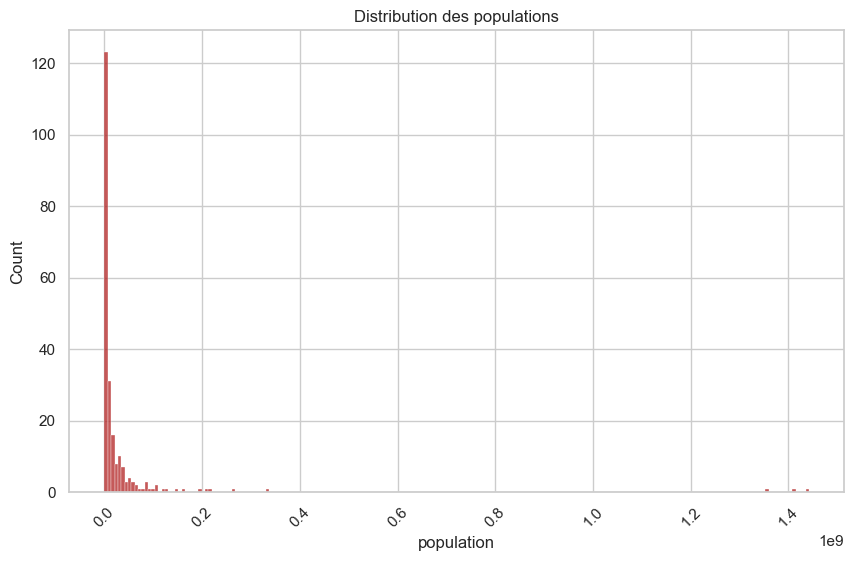

In [231]:
# Nous visualisons les infos et la distribution des prix
print(population['population'].describe())

plt.figure(figsize=(10,6))
sns.histplot(data=population['population'], color='firebrick')
plt.xticks(rotation=45)
plt.title('Distribution des populations')
plt.savefig('distribution_population.png', dpi=300, bbox_inches='tight')
plt.show()

In [232]:
#affichage des valeurs aberrantes 
print(detect_outliers(population['population']))
population.iloc[[39, 42, 100]]

39     1.442041e+09
42     1.410276e+09
100    1.354196e+09
Name: population, dtype: float64


,pays,population,evolution_pop
39,Chine,1.442041e+09,0.043741
42,"Chine, continentale",1.410276e+09,0.044023
100,Inde,1.354196e+09,0.083874


In [233]:
top_population = population.sort_values('population', ascending=False)
top_population.head(10)

,pays,population,evolution_pop
39,Chine,1.442041e+09,0.043741
42,"Chine, continentale",1.410276e+09,0.044023
100,Inde,1.354196e+09,0.083874
63,États-Unis d'Amérique,3.297912e+08,0.056425
101,Indonésie,2.644989e+08,0.077440
157,Pakistan,2.163797e+08,0.101327
29,Brésil,2.085050e+08,0.058279
149,Nigéria,1.934959e+08,0.168185
18,Bangladesh,1.617940e+08,0.082839
65,Fédération de Russie,1.454525e+08,0.015194


In [234]:
#création d'un dataframe affichant les meilleurs pays en tenant compte de leur population et de l'évolution de celle-ci
def meilleuredemographie(df):
       df = df[(df.population > df.population.quantile(0.79)) & (df.evolution_pop > df.evolution_pop.quantile(0.79))]
       df = df.sort_values(by=['population', 'evolution_pop'], ascending=False).reset_index(drop=True)
       return df

In [235]:
meilleuredemographie = meilleuredemographie(population)
meilleuredemographie

,pays,population,evolution_pop
0,Nigéria,193495907.0,0.168185
1,Éthiopie,108197950.0,0.175236
2,République démocratique du Congo,84283273.0,0.212284
3,République-Unie de Tanzanie,56267032.0,0.198278
4,Ouganda,40127085.0,0.194018
5,Iraq,39621162.0,0.210905
6,Afghanistan,35643418.0,0.209120
7,Ghana,30222262.0,0.153779
8,Angola,30208628.0,0.226572
9,Yémen,30034389.0,0.176146


Le Nigéria est le pays qui dispose à la fois d'une grande population et d'une évolution importante avec +16% entre 2010 et 2017. L'indicateur d'évolution de la population est pertient car, un pays dont la croissance démographique est importante est un bon investissement sur le long terme.

## <font color='skyblue'> 2) PIB</font>


count       185.000000
mean      21119.214054
std       22125.365495
min         773.600000
25%        4894.600000
50%       13429.300000
75%       29501.100000
max      126144.000000
Name: pib_par_hab, dtype: float64


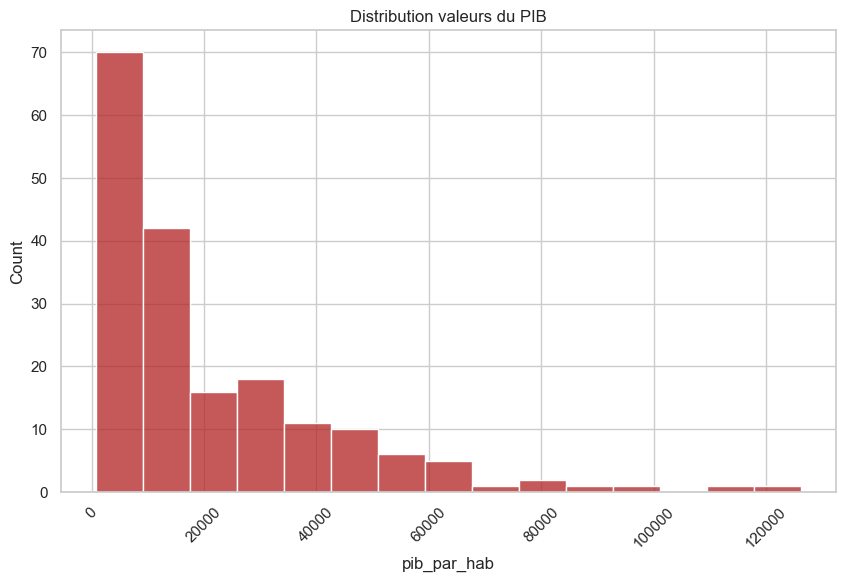

In [236]:
# Nous visualisons les infos et la distribution des prix
print(pib['pib_par_hab'].describe())

plt.figure(figsize=(10,6))
sns.histplot(data=pib['pib_par_hab'], color='firebrick')
plt.xticks(rotation=45)
plt.title('Distribution valeurs du PIB')
plt.savefig('distribution_pib.png', dpi=300, bbox_inches='tight')
plt.show()

In [237]:
#affichage des valeurs aberrantes 
print(detect_outliers(pib['pib_par_hab']))
pib.iloc[[39,100,139,159]]

39     126144.0
100    114986.0
139     91738.8
159     95310.3
Name: pib_par_hab, dtype: float64


,pays,pib_par_hab,evolution_pib
39,Chine - RAS de Macao,126144.0,-0.186755
100,Luxembourg,114986.0,0.024777
139,Qatar,91738.8,-0.049300
159,Singapour,95310.3,0.131200


In [238]:
top_pib = pib.sort_values('pib_par_hab', ascending=False)
top_pib.head(10)

,pays,pib_par_hab,evolution_pib
39,Chine - RAS de Macao,126144.0,-0.186755
100,Luxembourg,114986.0,0.024777
159,Singapour,95310.3,0.131200
139,Qatar,91738.8,-0.049300
22,Bermudes,81835.0,0.010419
82,Irlande,77749.2,0.317733
165,Suisse,69103.6,0.038541
51,Émirats arabes unis,67183.6,0.145784
123,Norvège,64050.8,0.032164
28,Brunéi Darussalam,60994.5,-0.132730


In [239]:
#création d'un dataframe affichant les meilleurs pays en tenant compte de leur pib et de l'évolution de celui-ci
def meilleurerichesse(df):
       df = df[(df.pib_par_hab > df.pib_par_hab.quantile(0.72)) & (df.evolution_pib > df.evolution_pib.quantile(0.72))]
       df = df.sort_values(by=['pib_par_hab', 'evolution_pib'], ascending=False).reset_index(drop=True)
       return df

In [240]:
meilleurerichesse = meilleurerichesse(pib)
meilleurerichesse

,pays,pib_par_hab,evolution_pib
0,Irlande,77749.2,0.317733
1,Émirats arabes unis,67183.6,0.145784
2,Malte,43559.3,0.220245
3,Tchéquie,38824.9,0.132307
4,Estonie,33821.9,0.142647
5,Lituanie,33761.9,0.190481
6,Panama,30446.8,0.172448
7,Pologne,30064.5,0.153247
8,Hongrie,29501.1,0.158486
9,Lettonie,28673.6,0.164025


L'irlande est le pays qui dispose du plus important PIB par habitant avec une très forte évolution de +31% en 7 ans. (il s'agit d'un paradis fiscal peu peuplé). L'indicateur évolution du pib n'est pas pertinent, en effet un pib grandissant n'indique pas une plus grande consommation de volaille.

## <font color='skyblue'> 3) Stabilité</font>


count    196.000000
mean      -0.049592
std        0.982514
min       -2.940000
25%       -0.642500
50%        0.040000
75%        0.772500
max        1.920000
Name: indice_stabilite, dtype: float64


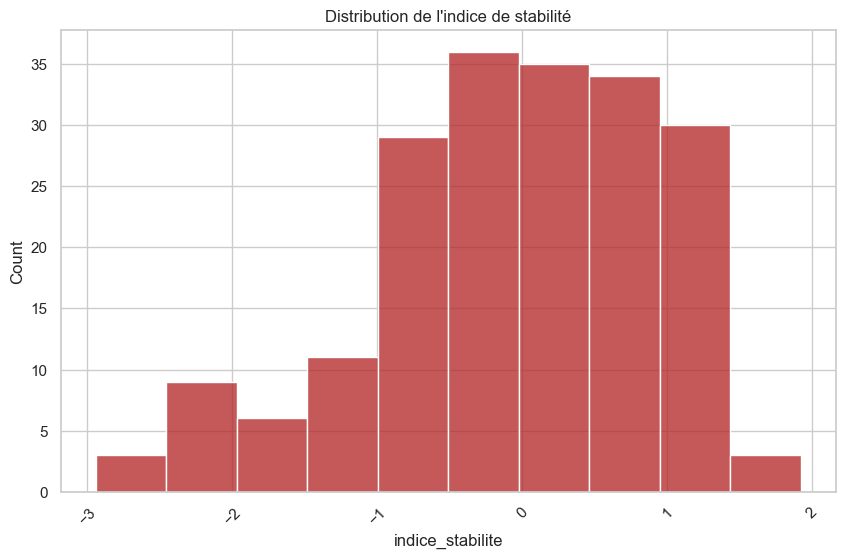

In [241]:
# Nous visualisons les infos et la distribution des prix
print(stabilite['indice_stabilite'].describe())

plt.figure(figsize=(10,6))
sns.histplot(data=stabilite['indice_stabilite'], color='firebrick')
plt.xticks(rotation=45)
plt.title('Distribution de l\'indice de stabilité')
plt.savefig('distribution_stabilite.png', dpi=300, bbox_inches='tight')
plt.show()

In [242]:
#affichage des valeurs aberrantes 
print(detect_outliers(stabilite['indice_stabilite']))
stabilite.iloc[[]]

Series([], Name: indice_stabilite, dtype: float64)


,pays,indice_stabilite,evolution_stabilite


In [243]:
top_stabilite = stabilite.sort_values('indice_stabilite', ascending=False)
top_stabilite.head(10)

,pays,indice_stabilite,evolution_stabilite
72,Groenland,1.92,0.140625
167,Singapour,1.62,0.277778
129,Nouvelle-Zélande,1.60,0.225000
39,Chine - RAS de Macao,1.43,0.601399
6,Andorre,1.42,0.098592
88,Islande,1.35,0.244444
105,Luxembourg,1.33,-0.097744
174,Suisse,1.26,0.000000
112,Malte,1.25,0.000000
187,Tuvalu,1.24,-0.145161


In [244]:
#création d'un dataframe affichant les meilleurs pays en tenant compte de leur stabilité et de l'évolution de celle-ci
def meilleurestabilite(df):
       df = df[(df.indice_stabilite > df.indice_stabilite.quantile(0.67)) & (df.evolution_stabilite > df.evolution_stabilite.quantile(0.67))]
       df = df.sort_values(by=['indice_stabilite', 'indice_stabilite'], ascending=False).reset_index(drop=True)
       return df

In [245]:
meilleurestabilite = meilleurestabilite(stabilite)
meilleurestabilite

,pays,indice_stabilite,evolution_stabilite
0,Singapour,1.62,0.277778
1,Chine - RAS de Macao,1.43,0.601399
2,Islande,1.35,0.244444
3,Samoa américaines,1.22,0.245902
4,Dominique,1.20,0.250000
5,Samoa,1.18,0.347458
6,Bhoutan,1.12,0.339286
7,Portugal,1.12,0.357143
8,Grenade,1.01,0.485149
9,Maurice,0.97,0.340206


Le pays le plus stable et dont l'évolution de la stabilité est importante est Singapour. L'indicateur d'évolution de l'indice de stabilité n'est pas pertinent, en effet, les pays qui ont la plus grande évolution sont des pays qui était dans des situations très instables par le passé, il peinent à arriver au niveau de stabilité des pays dits stables malgré une forte évolution. 

## <font color='skyblue'> 4) disponibilité</font>


count    178.000000
mean      20.435730
std       15.968738
min        0.410000
25%        7.295000
50%       17.950000
75%       29.165000
max       72.700000
Name: dispo_volaille_kg_p_an, dtype: float64


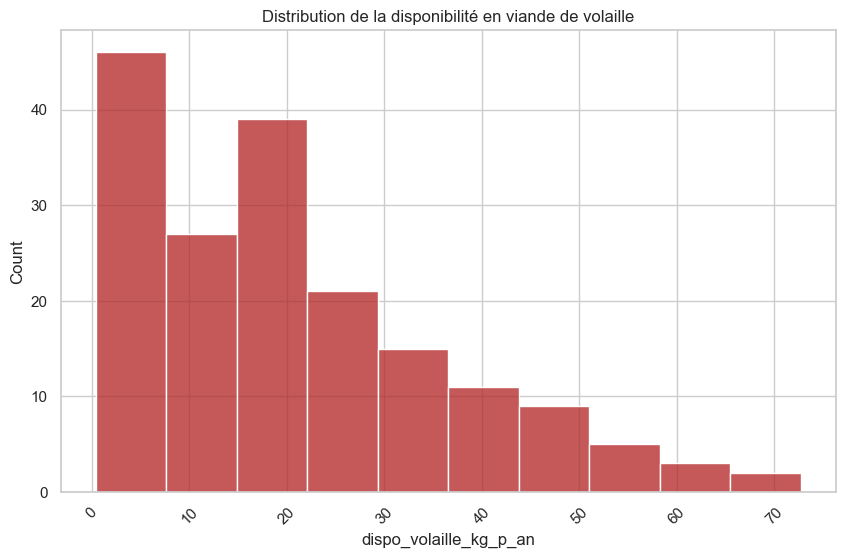

In [246]:
# Nous visualisons les infos et la distribution des prix
print(disponibilite['dispo_volaille_kg_p_an'].describe())

plt.figure(figsize=(10,6))
sns.histplot(data=disponibilite['dispo_volaille_kg_p_an'], color='firebrick')
plt.xticks(rotation=45)
plt.title('Distribution de la disponibilité en viande de volaille')
plt.savefig('distribution_disponibilite.png', dpi=300, bbox_inches='tight')
plt.show()

In [247]:
#affichage des valeurs aberrantes 
print(detect_outliers(disponibilite['dispo_volaille_kg_p_an']))
disponibilite.iloc[[147]]

147    72.7
Name: dispo_volaille_kg_p_an, dtype: float64


,pays,dispo_volaille_kg_p_an,evolution_dispo
147,Saint-Vincent-et-les Grenadines,72.7,-0.000275


In [248]:
top_disponibilite = disponibilite.sort_values('dispo_volaille_kg_p_an', ascending=False)
top_disponibilite.head(10)

,pays,dispo_volaille_kg_p_an,evolution_dispo
147,Saint-Vincent-et-les Grenadines,72.70,-0.000275
81,Israël,67.29,0.023480
148,Samoa,65.04,0.027060
166,Trinité-et-Tobago,61.80,0.012621
145,Sainte-Lucie,60.75,-0.063868
7,Antigua-et-Barbuda,57.31,-0.139417
55,États-Unis d'Amérique,55.80,0.087097
146,Saint-Kitts-et-Nevis,51.87,-0.187006
14,Bahamas,51.68,-0.134094
83,Jamaïque,51.09,-0.002936


In [249]:
#création d'un dataframe affichant les meilleurs pays en tenant compte de leur dispo et de l'évolution de celle-ci
def meilleuredisponibilite(df):
       df = df[(df.dispo_volaille_kg_p_an > df.dispo_volaille_kg_p_an.quantile(0.72)) & (df.evolution_dispo > df.evolution_dispo.quantile(0.72))]
       df = df.sort_values(by=['dispo_volaille_kg_p_an', 'dispo_volaille_kg_p_an'], ascending=False).reset_index(drop=True)
       return df

In [250]:
meilleuredisponibilite = meilleuredisponibilite(disponibilite)
meilleuredisponibilite

,pays,dispo_volaille_kg_p_an,evolution_dispo
0,Brésil,47.65,0.209654
1,Argentine,44.66,0.235558
2,Seychelles,40.39,0.258975
3,Guyana,40.18,0.208561
4,Pérou,38.05,0.261498
5,République dominicaine,35.17,0.222349
6,Pologne,33.53,0.206382
7,Colombie,33.52,0.271181
8,Fédération de Russie,31.85,0.300157
9,Myanmar,31.13,0.354963


Le Brésil dispose d'une quantité de volaille par habitant importante couplée d'une évolution notable de cet indicateur en 7ans. L'indicateur d'évolution de la disponibilité alimentaire sera conservé pour la suite.

## <font color='skyblue'> 5) commerce</font>


In [251]:
commerce.head()

,pays,production_volaille_en_t,importation_volaille_en_t,evolution_import,exportation_volaille_en_t,indice_dependance_import
0,Pays-Bas (Royaume des),1099000.0,608000.0,0.016447,1418000.0,0.553230
1,Afghanistan,28000.0,29000.0,-0.344828,NaN,1.035714
2,Afrique du Sud,1665000.0,514000.0,0.521401,63000.0,0.308709
3,Albanie,13000.0,20000.0,-0.250000,0.0,1.538462
4,Algérie,284000.0,2000.0,1.000000,0.0,0.007042


count    175.000000
mean       2.016613
std        4.712239
min        0.000000
25%        0.022245
50%        0.244898
75%        1.176515
max       37.791667
Name: indice_dependance_import, dtype: float64


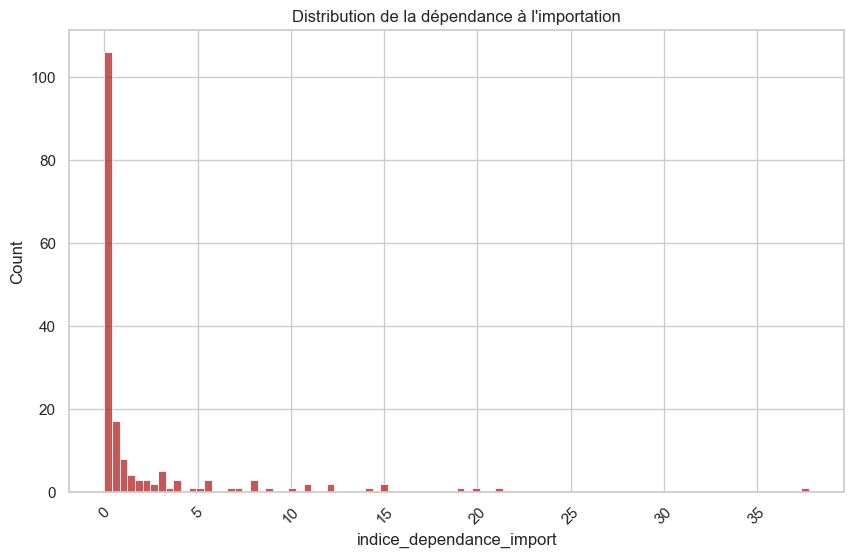

In [252]:
# Nous visualisons les infos et la distribution des prix
print(commerce['indice_dependance_import'].describe())

plt.figure(figsize=(10,6))
sns.histplot(data=commerce['indice_dependance_import'], color='firebrick')
plt.xticks(rotation=45)
plt.title('Distribution de la dépendance à l\'importation')
plt.savefig('distribution_importation.png', dpi=300, bbox_inches='tight')
plt.show()

In [253]:
#affichage des valeurs aberrantes 
print(detect_outliers(commerce['indice_dependance_import']))
commerce.iloc[[33,60,97,119]]

33     37.791667
60     19.000000
97     20.000000
119    21.000000
Name: indice_dependance_import, dtype: float64


,pays,production_volaille_en_t,importation_volaille_en_t,evolution_import,exportation_volaille_en_t,indice_dependance_import
33,Chine - RAS de Hong-Kong,24000.0,907000.0,-0.278942,663000.0,37.791667
60,Gabon,4000.0,76000.0,0.302632,0.0,19.000000
97,Macédoine du Nord,2000.0,40000.0,0.175000,1000.0,20.000000
119,Oman,6000.0,126000.0,0.380952,16000.0,21.000000


In [254]:
top_dependanceimportation = commerce.sort_values('indice_dependance_import', ascending=False)
top_dependanceimportation.head(10)

,pays,production_volaille_en_t,importation_volaille_en_t,evolution_import,exportation_volaille_en_t,indice_dependance_import
33,Chine - RAS de Hong-Kong,24000.0,907000.0,-0.278942,663000.0,37.791667
119,Oman,6000.0,126000.0,0.380952,16000.0,21.000000
97,Macédoine du Nord,2000.0,40000.0,0.175000,1000.0,20.000000
60,Gabon,4000.0,76000.0,0.302632,0.0,19.000000
129,Polynésie française,1000.0,15000.0,0.066667,0.0,15.000000
40,Congo,7000.0,104000.0,0.778846,0.0,14.857143
39,Comores,1000.0,14000.0,0.214286,0.0,14.000000
27,Cabo Verde,1000.0,12000.0,0.333333,NaN,12.000000
162,Timor-Leste,1000.0,12000.0,0.583333,NaN,12.000000
135,République démocratique du Congo,10000.0,109000.0,0.376147,0.0,10.900000


In [255]:
#création d'un dataframe affichant les meilleurs pays en tenant compte de leur dependance et de l'évolution de celle-ci
def meilleureimportation(df):
       df = df[(df.indice_dependance_import > df.indice_dependance_import.quantile(0.70)) & (df.evolution_import > df.evolution_import.quantile(0.70))]
       df = df.sort_values(by=['indice_dependance_import', 'evolution_import'], ascending=False).reset_index(drop=True)
       return df

In [256]:
meilleureimportation = meilleureimportation(commerce)
meilleureimportation

,pays,production_volaille_en_t,importation_volaille_en_t,evolution_import,exportation_volaille_en_t,indice_dependance_import
0,Congo,7000.0,104000.0,0.778846,0.0,14.857143
1,Timor-Leste,1000.0,12000.0,0.583333,NaN,12.000000
2,Cuba,29000.0,312000.0,0.528846,NaN,10.758621
3,Gambie,2000.0,16000.0,0.750000,NaN,8.000000
4,Mauritanie,5000.0,24000.0,0.708333,NaN,4.800000
5,Papouasie-Nouvelle-Guinée,7000.0,24000.0,0.791667,NaN,3.428571
6,Libéria,15000.0,48000.0,0.770833,NaN,3.200000
7,Namibie,10000.0,29000.0,0.862069,12000.0,2.900000
8,Guinée,15000.0,37000.0,0.783784,NaN,2.466667
9,Guinée-Bissau,3000.0,4000.0,0.750000,NaN,1.333333


Le Congo produit peu de volaille, il a une dépendance à l'import importante et une évolution de ses importation de 77% entre 2010 et 2017. Les 3 indicateurs sont pertienents pour la suite.

# <a name="C4"> C) Analyse multivariée </a>
***


## <font color='skyblue'> 1) Classement des pays en fonction des variables pertinentes</font>


Création d'une fonction qui selectionne les meilleurs pays en prenant en compte toutes les variables. Cette selection part du principe que toutes les variables ont la même importance, dans la réalité, certaines variables peuvent être plus déterminantes que d'autres pour réaliser un choix. 
- Création de "dataframe" en retirant les variables non pertinentes:

In [257]:
dataframe = dataframe0.filter(['pays','population','evolution_pop','pib_par_hab','indice_stabilite','dispo_volaille_kg_p_an','production_volaille_en_t','importation_volaille_en_t','indice_dependance_import','exportation_volaille_en_t'], axis=1)
dataframe.head()


,pays,population,evolution_pop,pib_par_hab,indice_stabilite,dispo_volaille_kg_p_an,production_volaille_en_t,importation_volaille_en_t,indice_dependance_import,exportation_volaille_en_t
0,Afghanistan,35643418.0,0.209120,2058.4,-2.80,1.76,28000.0,29000.0,1.035714,0.0
1,Afrique du Sud,56641209.0,0.085738,13860.3,-0.28,37.01,1665000.0,514000.0,0.308709,63000.0
2,Albanie,2879355.0,-0.011823,12771.0,0.38,11.45,13000.0,20000.0,1.538462,0.0
3,Algérie,41136546.0,0.128358,11737.4,-0.92,6.91,284000.0,2000.0,0.007042,0.0
4,Allemagne,82624374.0,0.015725,53071.5,0.59,18.05,1514000.0,842000.0,0.556143,646000.0


In [258]:
#correction chine sur dataframe
liste = ["Chine", 1442041, 0.043741, 8817, 0, 14.09, 19090000, 1543000, 0.080827, 1248000 ]
dataframe.loc[len(dataframe)] = liste

In [259]:
dataframe.loc[dataframe['pays']=='Chine']

,pays,population,evolution_pop,pib_par_hab,indice_stabilite,dispo_volaille_kg_p_an,production_volaille_en_t,importation_volaille_en_t,indice_dependance_import,exportation_volaille_en_t
167,Chine,1442041.0,0.043741,8817.0,0.0,14.09,19090000.0,1543000.0,0.080827,1248000.0


In [260]:
#création d'un dataframe affichant les meilleurs pays en tenant compte des variables dites pertinentes
def meilleuretout(df):
        df = df[(df.population > df.population.quantile(0.30)) 
               & (df.evolution_pop > df.evolution_pop.quantile(0.30))
                & (df.indice_stabilite > df.indice_stabilite.quantile(0.30))
                & (df.pib_par_hab > df.pib_par_hab.quantile(0.30))
                & (df.dispo_volaille_kg_p_an > df.dispo_volaille_kg_p_an.quantile(0.30))
                & (df.indice_dependance_import > df.indice_dependance_import.quantile(0.30))]
        df = df.sort_values(by=['indice_dependance_import'], ascending=False).reset_index(drop=True)
        return df

In [261]:
meilleurtout = meilleuretout(dataframe)
meilleurtout

,pays,population,evolution_pop,pib_par_hab,indice_stabilite,dispo_volaille_kg_p_an,production_volaille_en_t,importation_volaille_en_t,indice_dependance_import,exportation_volaille_en_t
0,Oman,4541854.0,0.365476,33308.5,0.75,21.63,6000.0,126000.0,21.000000,16000.0
1,Émirats arabes unis,9068296.0,0.064679,67183.6,0.62,25.97,57000.0,465000.0,8.157895,31000.0
2,Angola,30208628.0,0.226572,7310.9,-0.38,10.65,40000.0,277000.0,6.925000,0.0
3,Koweït,4124904.0,0.286443,50855.6,-0.05,46.25,56000.0,137000.0,2.446429,4000.0
4,Kazakhstan,18314814.0,0.092110,24863.0,0.03,18.24,171000.0,174000.0,1.017544,6000.0
5,Autriche,8797496.0,0.049408,54173.0,1.05,18.20,148000.0,110000.0,0.743243,78000.0
6,Irlande,4771854.0,0.051818,77749.2,1.00,23.95,146000.0,99000.0,0.678082,93000.0
7,Suisse,8451687.0,0.074453,69103.6,1.26,15.72,92000.0,51000.0,0.554348,4000.0
8,Suède,10058190.0,0.067255,51948.0,0.98,16.59,157000.0,84000.0,0.535032,23000.0
9,Royaume-Uni de Grande-Bretagne et d'Irlande du...,66064804.0,0.050023,46372.4,0.39,32.66,1839000.0,779000.0,0.423600,359000.0


Extraction des données sur l'évolution des variables. Nous les mettrons en corrélations à la fin de notre étude pour mettre en avant un pays ou un autre.

In [262]:
#remplacement des valeurs NaN par 0 (Des valeurs étaient aberrantes suites au calcul d'evolution)
dataframe.fillna(0, inplace=True)

In [263]:
info_donnee(dataframe)

,nombre de valeurs non nulles,nombre de valeurs uniques,type de donnée,nombre de valeurs nulles,pourcentage de valeurs nulles
colonne,,,,,
pays,168,168,object,0,0.0
population,168,168,float64,0,0.0
evolution_pop,168,168,float64,0,0.0
pib_par_hab,168,168,float64,0,0.0
indice_stabilite,168,128,float64,0,0.0
dispo_volaille_kg_p_an,168,166,float64,0,0.0
production_volaille_en_t,168,120,float64,0,0.0
importation_volaille_en_t,168,86,float64,0,0.0
indice_dependance_import,168,136,float64,0,0.0


Notre dataframe final dispose de 9 variables discriminantes qui pourront être utilisée afin de réaliser notre clustering. 167 pays sont disponibles dans notre jeu de données.

## <font color='skyblue'> 2) Corrélations entre les variables</font>


<Axes: >

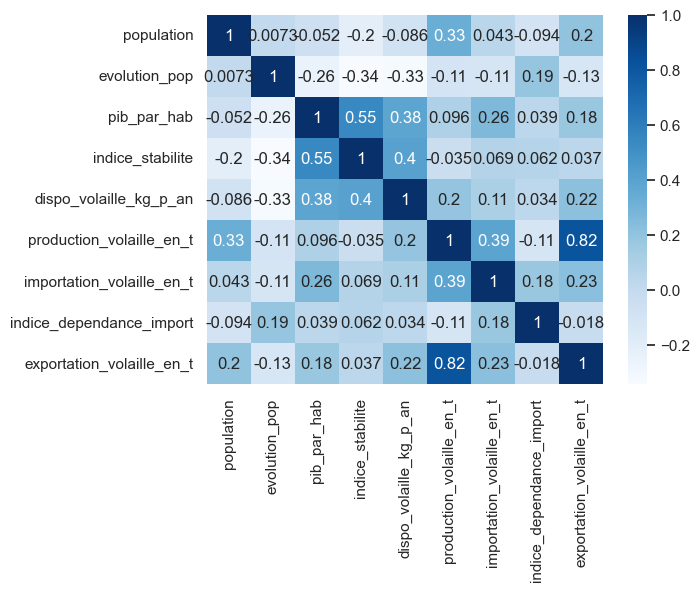

In [264]:
# Calculer et afficher la matrice de corrélation
matriceheatmap = dataframe.corr()
sns.heatmap(matriceheatmap, annot=True, cmap="Blues")

Plusieurs corrélations sont visibles :
- la production est corrélée à la population 
- la disponibilité en viande de volaille est corrélée à l'indice de stabilité et au PIB
- pour finir l'indice de stabilité est très fortement correlé au PIB 

Mais aussi :
- l'évolution des importations est plutot correlée à l'evolution de la disponibilité
- la dépendance à l'importation est plutot correlée à l'évolution de la population
- la production est plutot correlée au PIB

## <font color='skyblue'> 3) Conclusion </font>


Agglomération des données de notre analyse univariée et multivariée afin de dégager les pays les plus propices à la vente de viande de volaille. Les pays qui apparaissent dans plusieurs classement sont considérés comme propices.

In [265]:
# Récupérer les noms de pays
pays1 = meilleuredemographie.pays.unique()
pays2 = meilleuredisponibilite.pays.unique()
pays3 = meilleureimportation.pays.unique()
pays4 = meilleurerichesse.pays.unique()
pays5 = meilleurestabilite.pays.unique()
pays6 = meilleurtout.pays.unique()

# Combiner les noms des pays en une seule liste
tous_les_pays = pays1.tolist() + pays2.tolist() + pays3.tolist() + pays4.tolist() + pays5.tolist()+ pays6.tolist()

# Utiliser set pour trouver les indices des pays qui apparaissent dans au moins 2 dataframes
pays_multiples = set([i for i in range(len(tous_les_pays)) if tous_les_pays.count(tous_les_pays[i]) > 1])

# Afficher les pays qui apparaissent dans plusieurs dataframes
for i in pays_multiples:
    print(tous_les_pays[i])

Angola
Seychelles
République dominicaine
Pologne
Cuba
Lituanie
Cuba
Irlande
Émirats arabes unis
Lituanie
Panama
Pologne
Seychelles
Cuba
Émirats arabes unis
Angola
Irlande
République dominicaine
Panama


Liste des pays qui apparaissent le plus dans notre analyse préliminaire : 
Europe : 
 - Irlande
 - Lituanie 
 - Pologne

Moyen orient :
 - Émirats arabes unis 

Amérique :
 - République dominicaine 
 - Panama 
 - Cuba 

Autre :
 - Seychelles

En conclusion préliminaire, nous conseillons l'un de ces 8 pays pour une internationalisation. Une implentation multiple en Amérique pourrait être pertinente. 

## <font color='skyblue'> 4) Preparation présentation </font>


Ce chapitre permet uniquement d'obtenir des informations supplémentaires afin d'alimenter le storytelling de la présentation.

In [266]:
#création d'une copie du df
dataframeponderee=dataframe.copy()

#extraction des valeurs maximales pour calcul valeurs pondérées
max_popdf = max(dataframe.population)
max_evopopdf = max(dataframe.evolution_pop)
max_pibdf = max(dataframe.pib_par_hab)
max_stabdf = max(dataframe.indice_stabilite)
max_dispodf = max(dataframe.dispo_volaille_kg_p_an)
max_dependdf = max(dataframe.indice_dependance_import)
max_impodf = max(dataframe.importation_volaille_en_t)

#extraction des valeurs minimales pour calcul valeurs pondérées
min_evopopdf = min(dataframe.evolution_pop)
min_stabdf = min(dataframe.indice_stabilite)

In [267]:
abs(min_stabdf)


2.8

In [268]:
#calcul des valeurs pondérées pour chaque variable
dataframeponderee['population']=dataframeponderee['population']/max_popdf
dataframeponderee['evolution_pop']=(dataframeponderee['evolution_pop']+abs(min_evopopdf))/(max_evopopdf+abs(min_evopopdf))
dataframeponderee['pib_par_hab']=dataframeponderee['pib_par_hab']/max_pibdf
dataframeponderee['indice_stabilite']=(dataframeponderee['indice_stabilite']+abs(min_stabdf))/(max_stabdf+abs(min_stabdf))
dataframeponderee['dispo_volaille_kg_p_an']=dataframeponderee['dispo_volaille_kg_p_an']/max_dispodf
dataframeponderee['indice_dependance_import']=dataframeponderee['indice_dependance_import']/max_dependdf
dataframeponderee['importation_volaille_en_t']=dataframeponderee['importation_volaille_en_t']/max_impodf


In [269]:
#calcul d'un score où chaque variable a le meme poids 1/8
dataframeponderee['score_df']=(dataframeponderee['population'] + dataframeponderee['pib_par_hab'] + dataframeponderee['indice_stabilite']*10000 + dataframeponderee['dispo_volaille_kg_p_an'] + dataframeponderee['indice_dependance_import'] + dataframeponderee['evolution_pop']+ dataframeponderee['importation_volaille_en_t'])*100/10

dataframeponderee=dataframeponderee.sort_values(by=['score_df'], ascending=False).reset_index(drop=True)

dataframeponderee.head(10)

,pays,population,evolution_pop,pib_par_hab,indice_stabilite,dispo_volaille_kg_p_an,production_volaille_en_t,importation_volaille_en_t,indice_dependance_import,exportation_volaille_en_t,score_df
0,Nouvelle-Zélande,0.003505,0.461222,0.334685,1.000000,0.359147,223000.0,0.000648,0.000119,23000.0,100011.593262
1,Chine - RAS de Macao,0.000472,0.543735,1.000000,0.961364,0.467538,4000.0,0.014906,0.152150,0.0,96158.151641
2,Islande,0.000254,0.440844,0.441071,0.943182,0.412517,10000.0,0.001296,0.005292,0.0,94331.194566
3,Luxembourg,0.000440,0.586437,0.911546,0.938636,0.252682,0.0,0.007129,0.000000,1000.0,93881.218704
4,Suisse,0.006241,0.442435,0.547815,0.922727,0.216231,92000.0,0.033052,0.014669,4000.0,92285.331709
5,Malte,0.000354,0.542493,0.345314,0.920455,0.373728,4000.0,0.005833,0.059537,0.0,92058.727134
6,Dominique,0.000052,0.344640,0.089908,0.909091,0.561073,0.0,0.002592,0.000000,0.0,90919.073556
7,Samoa,0.000153,0.419361,0.051418,0.904545,0.894635,0.0,0.011017,0.000000,0.0,90468.311309
8,Norvège,0.003897,0.440524,0.507759,0.902273,0.284457,101000.0,0.001296,0.000524,0.0,90239.657296
9,Portugal,0.007612,0.247587,0.261960,0.890909,0.420633,361000.0,0.053143,0.006011,44000.0,89100.878542


In [270]:
#calcul d'un score où chaque variable a le meme poids 1/8
dataframeponderee['score_df']=(dataframeponderee['population']*4 + dataframeponderee['pib_par_hab'] + dataframeponderee['indice_stabilite'] + dataframeponderee['dispo_volaille_kg_p_an'] + dataframeponderee['indice_dependance_import'] + dataframeponderee['evolution_pop']+ dataframeponderee['importation_volaille_en_t']*4)*100/13

dataframeponderee=dataframeponderee.sort_values(by=['score_df'], ascending=False).reset_index(drop=True)

dataframeponderee.head(10)

,pays,population,evolution_pop,pib_par_hab,indice_stabilite,dispo_volaille_kg_p_an,production_volaille_en_t,importation_volaille_en_t,indice_dependance_import,exportation_volaille_en_t,score_df
0,Chine - RAS de Hong-Kong,0.005510,0.384290,0.474396,0.825000,0.628473,24000.0,0.587816,1.000000,663000.0,43.734329
1,Chine,0.001065,0.383595,0.069896,0.636364,0.193810,19090000.0,1.000000,0.002139,1248000.0,40.692796
2,Inde,1.000000,0.460485,0.049015,0.463636,0.039065,3804000.0,0.000000,0.000000,4000.0,38.555392
3,Japon,0.093533,0.277967,0.328547,0.888636,0.254608,2215000.0,0.692806,0.012771,10000.0,37.752975
4,Mexique,0.090710,0.460545,0.156340,0.454545,0.464512,3249000.0,0.629942,0.007916,9000.0,34.049731
5,Allemagne,0.061014,0.329920,0.420722,0.770455,0.248281,1514000.0,0.545690,0.014716,646000.0,32.391603
6,Royaume-Uni de Grande-Bretagne et d'Irlande du...,0.048785,0.395631,0.367615,0.725000,0.449243,1839000.0,0.504861,0.011209,359000.0,32.025244
7,Arabie saoudite,0.025250,0.567688,0.375017,0.490909,0.523246,540000.0,0.482178,0.036457,47000.0,30.946364
8,États-Unis d'Amérique,0.243533,0.407896,0.474971,0.702273,0.767538,21914000.0,0.079715,0.000149,3692000.0,28.044748
9,Émirats arabes unis,0.006696,0.423709,0.532594,0.777273,0.357221,57000.0,0.301361,0.215865,31000.0,27.222249


In [271]:
dataframe.loc[dataframe['pays'] == "Japon"] 

,pays,population,evolution_pop,pib_par_hab,indice_stabilite,dispo_volaille_kg_p_an,production_volaille_en_t,importation_volaille_en_t,indice_dependance_import,exportation_volaille_en_t
78,Japon,126662472.0,-0.011392,41444.2,1.11,18.51,2215000.0,1069000.0,0.482619,10000.0


# <a name="C4"> D) Classification </a>
***

## <font color='skyblue'> 1) Classification ascendante hiérarchique </font>


Il existe de nombreuses techniques statistiques visant à partinionner une population en différentes classes ou sous-groupes. La classification ascendante hiérarchique (CAH) est l’une d’entre elles.
Il s'agira de rassembler les pays selon les similitudes des différentes variables, qui s’exprimeront sous la forme d’une matrice de distances, indiquant la distance entre chaque individu pris 2 à 2. 2 observations identiques auront une distance nulle. Plus les deux observations seront dissemblables, plus la distance sera importante. 

- <font color='skyblue'> **Préparation et dendrogramme** </font>

Afin d'afficher notre liste de pays classée sur un dendrogramme, il s'agira de standardiser le jeu de données, puis de le mettre à une échelle cohérente, enfin il s'agira de les lier. Des outils prédéfinis existent pour cela, ils seront utilisés (StandardScaler,transform,linkage)

In [272]:
#Copie du dataframe
df_final=dataframe.copy()
#Mettre la colonne Pays en index
df_final=df_final.set_index('pays')
df_final.head(1)

,population,evolution_pop,pib_par_hab,indice_stabilite,dispo_volaille_kg_p_an,production_volaille_en_t,importation_volaille_en_t,indice_dependance_import,exportation_volaille_en_t
pays,,,,,,,,,
Afghanistan,35643418.0,0.20912,2058.4,-2.8,1.76,28000.0,29000.0,1.035714,0.0


In [273]:
# préparation des données pour le clustering
#création de la variable "variables" contenant toutes les valeurs du dataframe
variables = df_final.values
#création d'un dataframe avec la liste des pays
liste_pays = df_final.index

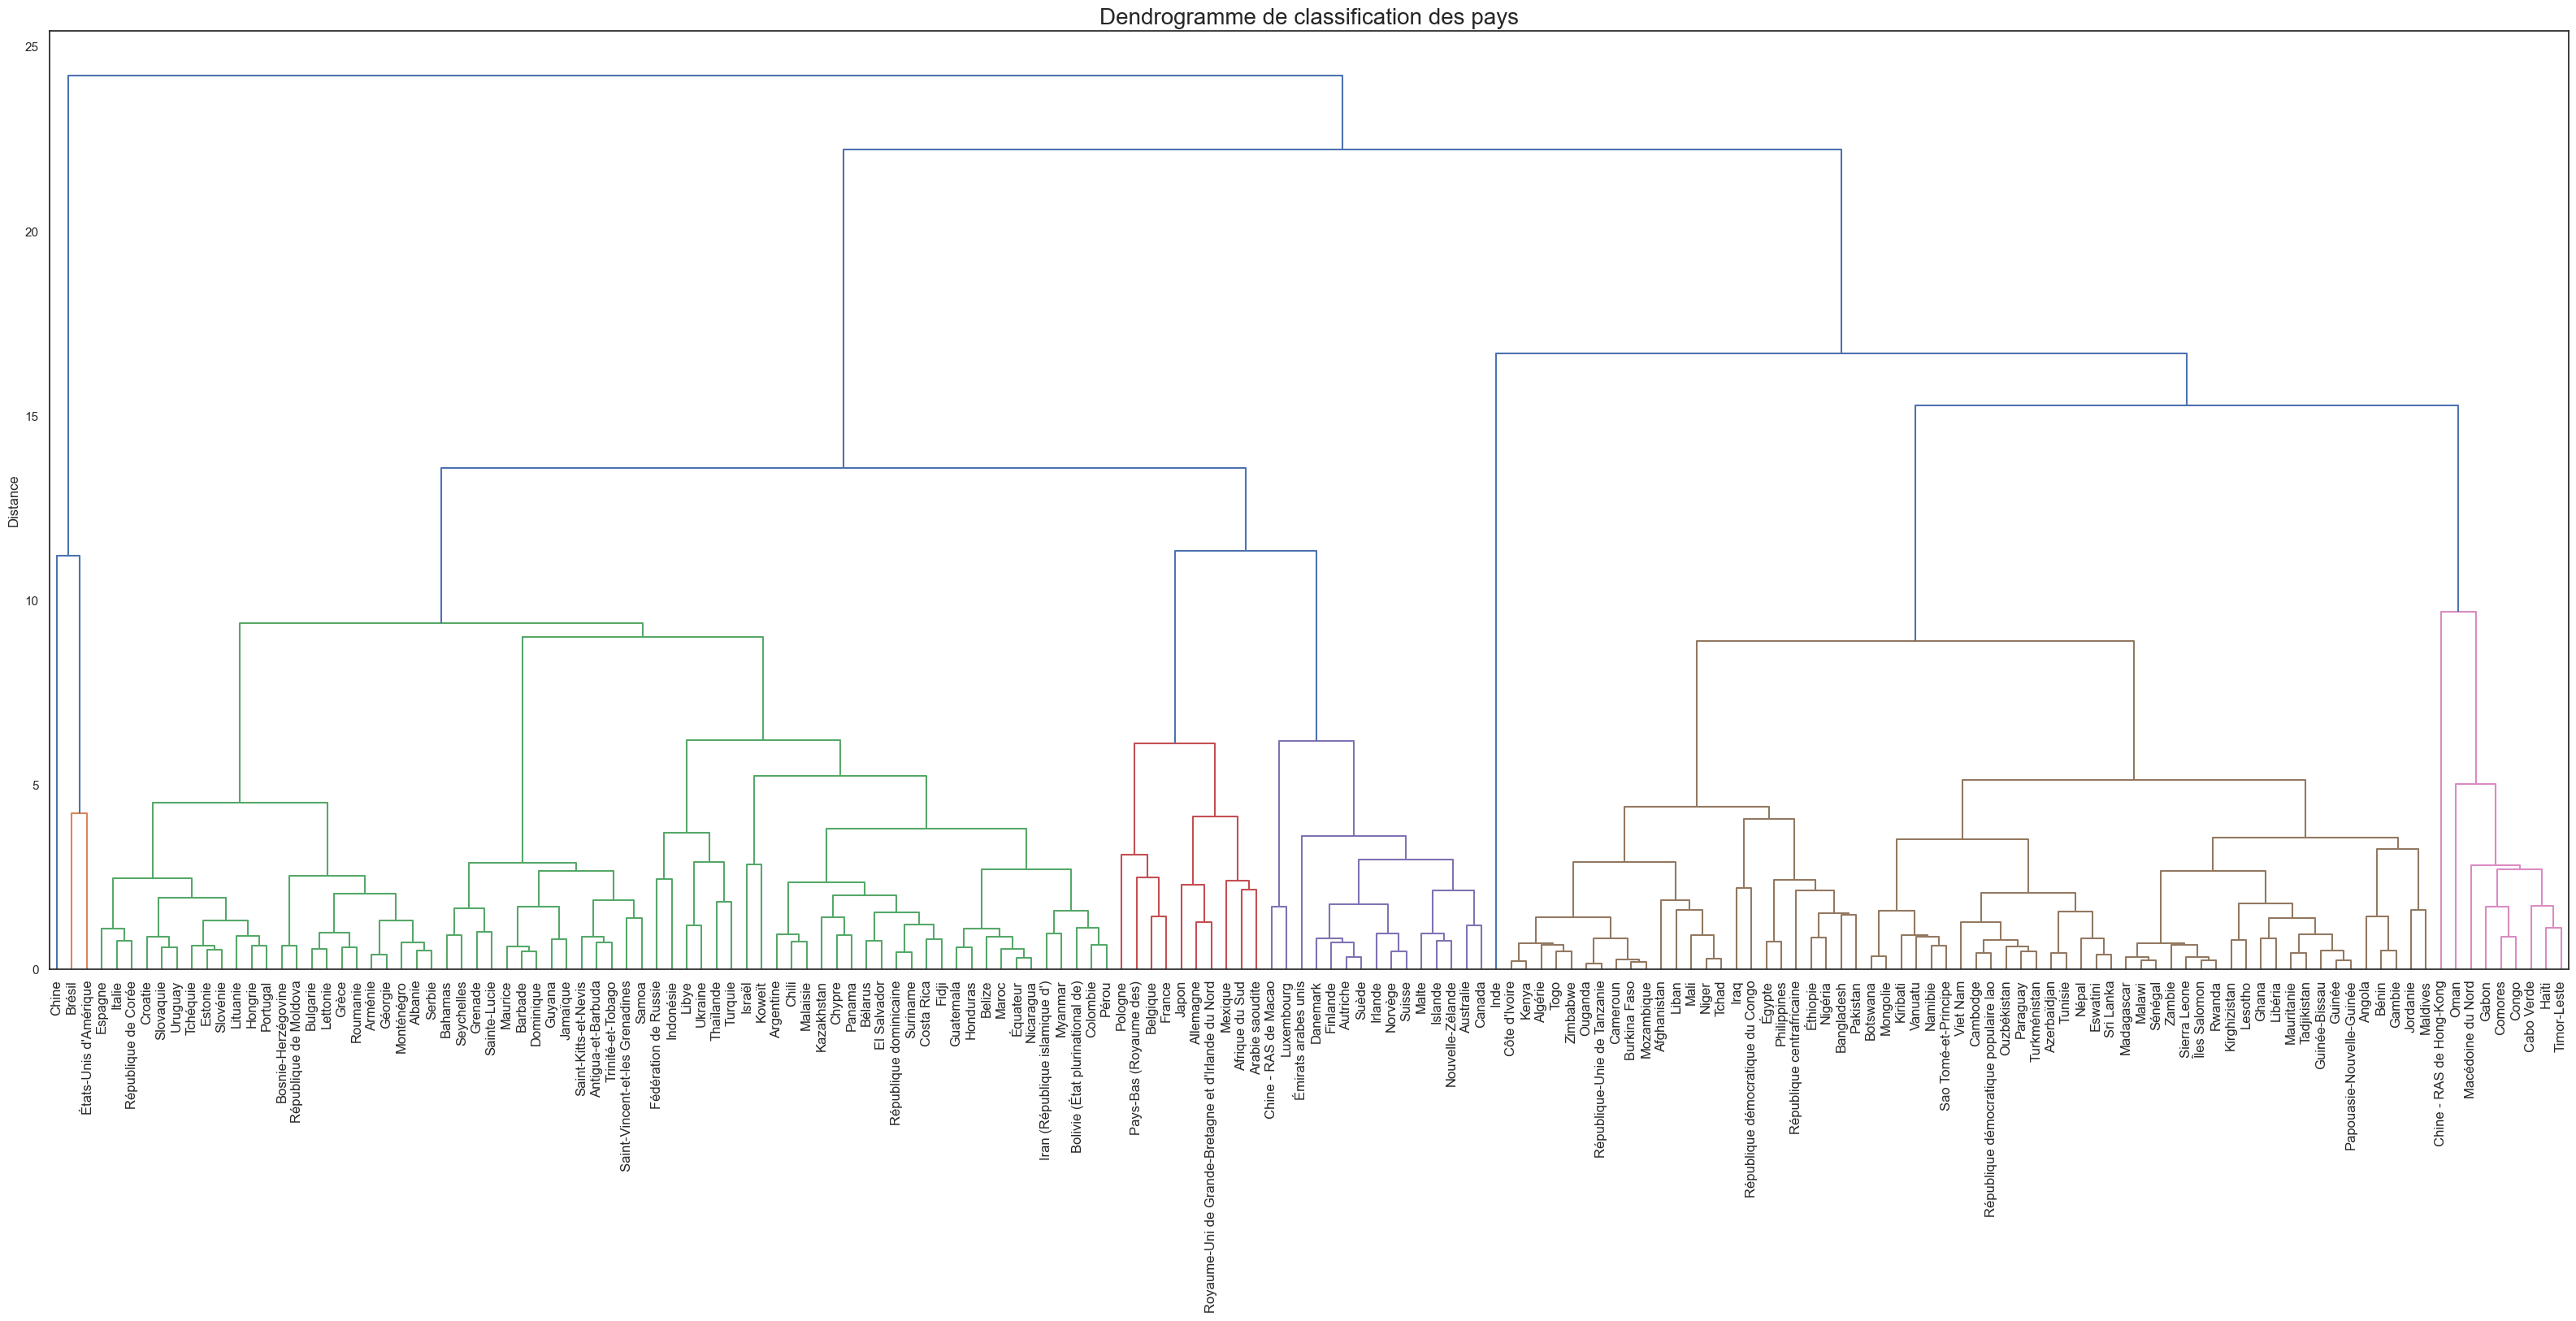

In [274]:
# Centrage et Réduction
from sklearn import preprocessing

variables_standard = preprocessing.StandardScaler().fit(variables)
variables_echelle = variables_standard.transform(variables)

# classification hiérarchique
from scipy.cluster.hierarchy import linkage, fcluster

#produire un arbre de liens hiérarchiques
link_variables = linkage(variables_echelle, method = 'ward', metric='euclidean')
#Ward qui est basé sur la moyenne équivalente des distances de variance entre chaque groupe, 
# et la métrique euclidienne qui mesure la distance euclidienne entre deux points dans un espace multidimensionnel

# affichage dendrogramme
from scipy.cluster.hierarchy import dendrogram

fig =plt.figure(figsize=(40,15))
sns.set_style('white')
plt.title('Dendrogramme de classification des pays', fontsize=20)
plt.ylabel('Distance')
dendrogram(link_variables, labels = df_final.index, leaf_font_size=12, color_threshold=10, orientation='top')
plt.savefig('dendrogramme.png')
plt.show()


- <font color='skyblue'> **Classification en 5 classes** </font>

5 classes apparaissent sur le dendrogramme précédent, création d'un nouveau graphique avec uniquement le nombre de pays dans chaque classe.

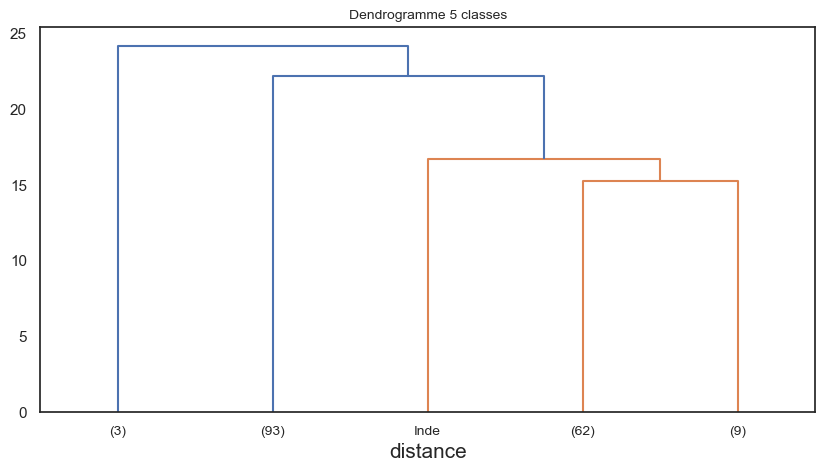

In [275]:
#division en 5 classes avec le nombre de pays dans chaque classe
fig = plt.figure(figsize=(10,5))
sns.set_style('white')
plt.title('Dendrogramme 5 classes', fontsize=10)
plt.xlabel('distance', fontsize=15)
dendrogram(link_variables, labels = df_final.index, p=5, truncate_mode='lastp', leaf_font_size=10)
plt.savefig('dendrogramme2.png')
plt.show()

Création de 5 dataframes représentant les 5 classes obtenues via notre classification.

In [276]:
# On récupère les données du dendrogramme
# puis on crée un DataFrame avec la liste des pays associée à leur cluster
classe = fcluster(link_variables, t=5, criterion='maxclust')
df_final_cah = pd.DataFrame({'pays' : df_final.index.tolist(),
                             'classe' : classe})
df_final_cah = df_final_cah.sort_values(['classe', 'pays'])

#jointure du dataframe avec la colonne cluster
df_final_cah = pd.merge(df_final, df_final_cah, on='pays')
df_final_cah.head(1)


,pays,population,evolution_pop,pib_par_hab,indice_stabilite,dispo_volaille_kg_p_an,production_volaille_en_t,importation_volaille_en_t,indice_dependance_import,exportation_volaille_en_t,classe
0,Afghanistan,35643418.0,0.20912,2058.4,-2.8,1.76,28000.0,29000.0,1.035714,0.0,3


In [277]:
#création d'un df par classe
classe1=df_final_cah[df_final_cah['classe']==1]
classe2=df_final_cah[df_final_cah['classe']==2]
classe3=df_final_cah[df_final_cah['classe']==3]
classe4=df_final_cah[df_final_cah['classe']==4]
classe5=df_final_cah[df_final_cah['classe']==5]

In [278]:
classe3

,pays,population,evolution_pop,pib_par_hab,indice_stabilite,dispo_volaille_kg_p_an,production_volaille_en_t,importation_volaille_en_t,indice_dependance_import,exportation_volaille_en_t,classe
0,Afghanistan,35643418.0,0.209120,2058.4,-2.80,1.76,28000.0,29000.0,1.035714,0.0,3
3,Algérie,41136546.0,0.128358,11737.4,-0.92,6.91,284000.0,2000.0,0.007042,0.0,3
5,Angola,30208628.0,0.226572,7310.9,-0.38,10.65,40000.0,277000.0,6.925000,0.0,3
12,Azerbaïdjan,10071567.0,0.082844,14121.4,-0.75,13.12,104000.0,27000.0,0.259615,0.0,3
14,Bangladesh,161793964.0,0.082839,4894.6,-1.26,1.61,249000.0,0.0,0.000000,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...
159,Turkménistan,5968383.0,0.117354,14205.0,-0.13,4.52,21000.0,10000.0,0.476190,0.0,3
163,Vanuatu,290239.0,0.154307,3081.5,0.70,16.29,1000.0,4000.0,4.000000,0.0,3
164,Viet Nam,94033048.0,0.070422,8996.4,0.23,9.81,874000.0,62000.0,0.070938,8000.0,3
165,Zambie,17298054.0,0.202680,3485.0,0.15,3.58,49000.0,12000.0,0.244898,1000.0,3


- <font color='skyblue'> **Analyse des classes** </font>

Affichage de nos 5 classes via boxplot afin de connaitre la distribution de chacune de nos variable à l'intérieur de chaque classe.

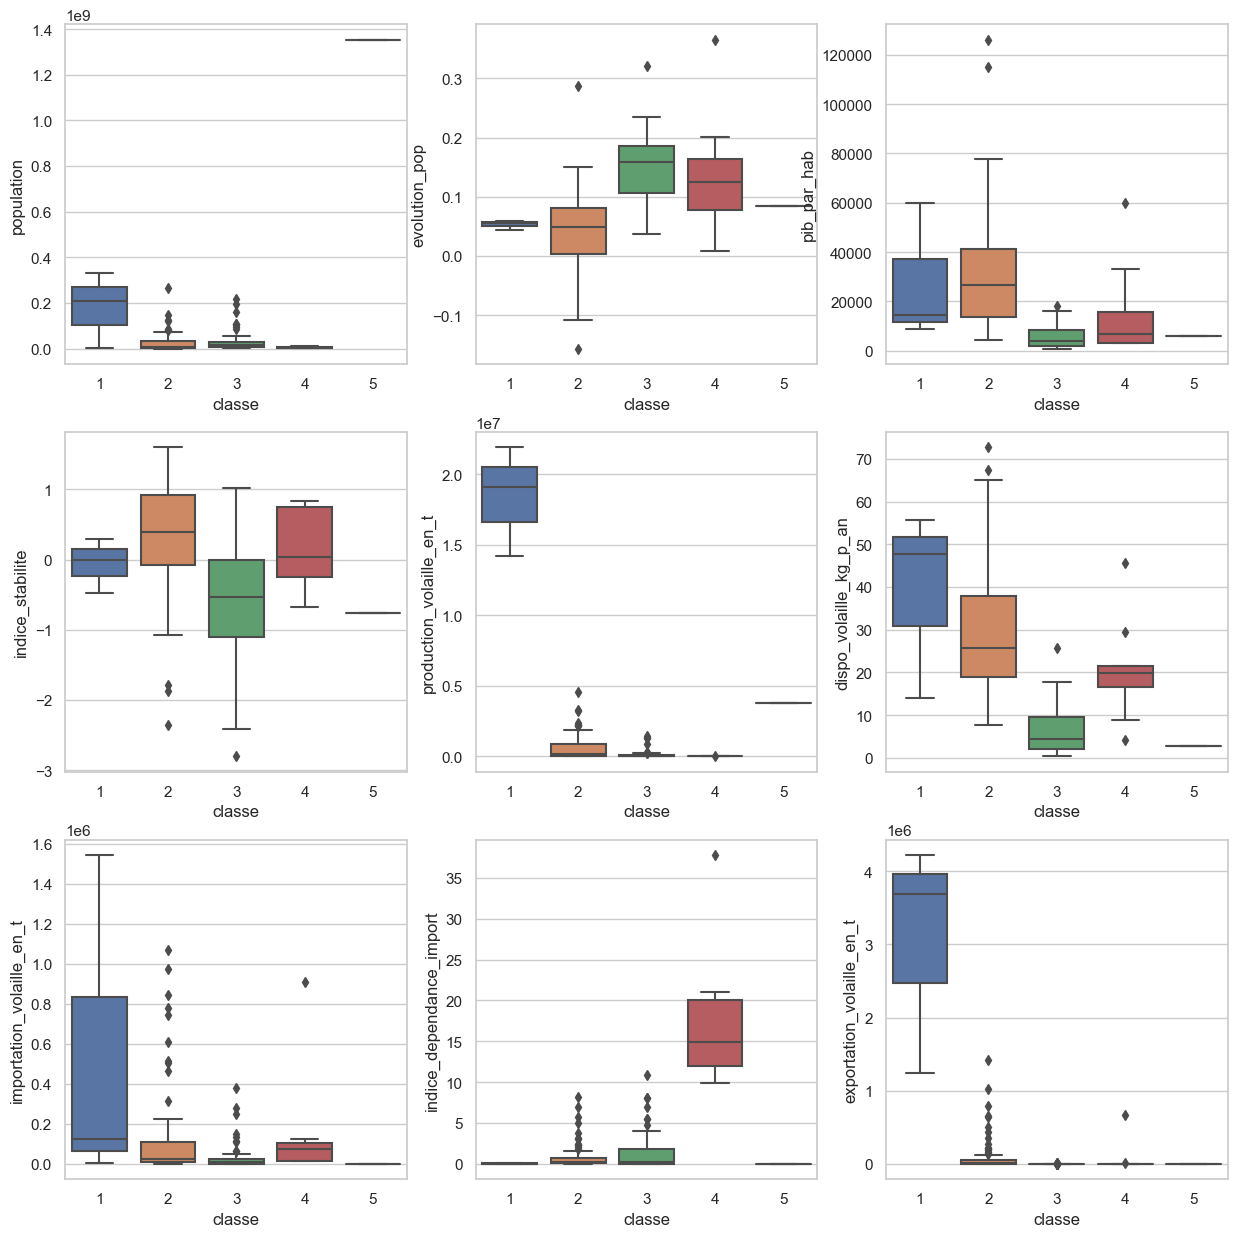

In [279]:
# affichage des variables en fonciton de la classe
plt.figure(figsize=(15, 15))
sns.set(style="whitegrid")
plt.subplot(6, 1, 1)

plt.subplot(331)
sns.boxplot(data=df_final_cah, x='classe', y='population')

plt.subplot(332)
sns.boxplot(data=df_final_cah, x='classe', y='evolution_pop')

plt.subplot(333)
sns.boxplot(data=df_final_cah, x='classe', y='pib_par_hab')

plt.subplot(334)
sns.boxplot(data=df_final_cah, x='classe', y='indice_stabilite')

plt.subplot(335)
sns.boxplot(data=df_final_cah, x='classe', y='production_volaille_en_t')

plt.subplot(336)
sns.boxplot(data=df_final_cah, x='classe', y='dispo_volaille_kg_p_an')

plt.subplot(337)
sns.boxplot(data=df_final_cah, x='classe', y='importation_volaille_en_t')

plt.subplot(338)
sns.boxplot(data=df_final_cah, x='classe', y='indice_dependance_import')

plt.subplot(339)
sns.boxplot(data=df_final_cah, x='classe', y='exportation_volaille_en_t')

plt.savefig("boxplotclasses.png")
plt.show()

- <font color='skyblue'> **Analyse des classes** </font>

In [280]:
#Création d'un dataframe des moyennes pour chaque classe 
df_final_cah_moyenne=df_final_cah.groupby('classe').mean().round (decimals=2) 
df_final_cah_moyenne.head()

,population,evolution_pop,pib_par_hab,indice_stabilite,dispo_volaille_kg_p_an,production_volaille_en_t,importation_volaille_en_t,indice_dependance_import,exportation_volaille_en_t
classe,,,,,,,,,
1,1.799127e+08,0.05,27752.13,-0.06,39.18,18390666.67,556333.33,0.03,3054333.33
2,2.276056e+07,0.04,30255.21,0.30,29.35,600720.43,113333.33,0.75,92387.10
3,3.057765e+07,0.15,5616.65,-0.60,6.53,132854.84,32887.10,1.40,887.10
4,3.889034e+06,0.14,16011.66,0.10,20.52,6111.11,153333.33,17.84,75555.56
5,1.354196e+09,0.08,6182.90,-0.76,2.84,3804000.00,0.00,0.00,4000.00


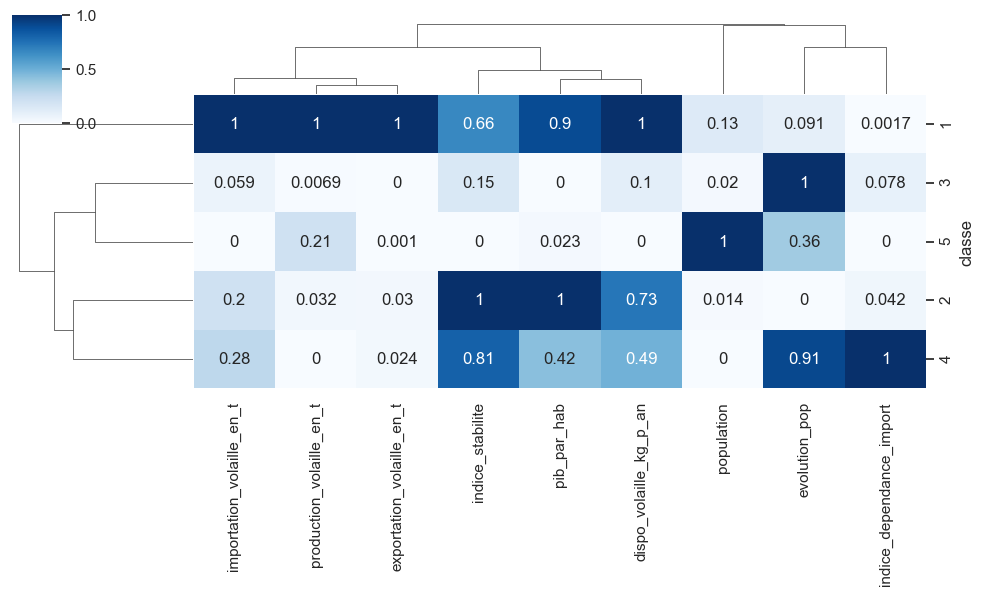

In [281]:
#Clustermap entre classes et variables
sns.clustermap(df_final_cah_moyenne, figsize=(10, 6), annot=True, standard_scale=1, cmap='Blues')
plt.savefig("clustermap.png")
plt.show()

- Classe 1 : Pays très gros producteur et exportateur de viande de volaille
- Classe 2 : Pays riches stables qui consomment et importent
- Classe 3 : Pays qui consomment mais n'exportent et n'importent pas
- Classe 4 : Pays pauvres qui consomment peu mais dépendent beaucoup des importations
- Classe 5 : Inde, très peuplén produit mais n'exporte pas


La classe 2 est la classe la plus intéressante pour la suite de notre étude.

- <font color='skyblue'> **Scoring des pays selon leur performances sur les variables** </font>

Afin de faire une selection à l'intérieur de notre classe, nous allons crée un dataframe avec les valeurs pondérées et les ajouter afin d'obtenir un score qui discriminera les pays en fonction de leur performances dans chaque domaine.

In [282]:
#création d'une copie du df
classe2ponderee=classe2.copy()

#extraction des valeurs maximales pour calcul valeurs pondérées
max_pop = max(classe2.population)
max_evopop = max(classe2.evolution_pop)
max_pib = max(classe2.pib_par_hab)
max_stab = max(classe2.indice_stabilite)
max_dispo = max(classe2.dispo_volaille_kg_p_an)
max_depend = max(classe2.indice_dependance_import)
max_impo = max(classe2.importation_volaille_en_t)

#extraction des valeurs minimales pour calcul valeurs pondérées
min_evopop = min(classe2.evolution_pop)
min_stab = min(classe2.indice_stabilite)

In [283]:
#calcul des valeurs pondérées pour chaque variable
classe2ponderee['population']=classe2ponderee['population']/max_pop
classe2ponderee['evolution_pop']=(classe2ponderee['evolution_pop']+abs(min_evopop))/(max_evopop+abs(min_evopop))
classe2ponderee['pib_par_hab']=classe2ponderee['pib_par_hab']/max_pib
classe2ponderee['indice_stabilite']=(classe2ponderee['indice_stabilite']+abs(min_stab))/(max_stab+abs(min_stab))
classe2ponderee['dispo_volaille_kg_p_an']=classe2ponderee['dispo_volaille_kg_p_an']/max_dispo
classe2ponderee['indice_dependance_import']=classe2ponderee['indice_dependance_import']/max_depend
classe2ponderee['importation_volaille_en_t']=classe2ponderee['importation_volaille_en_t']/max_impo

In [284]:
#calcul d'un score où chaque variable a le meme poids hormis la populatione et l'importation qui ont un coef de 4
classe2ponderee['score_cah']=(classe2ponderee['population']*4 + classe2ponderee['pib_par_hab'] + classe2ponderee['indice_stabilite'] + classe2ponderee['dispo_volaille_kg_p_an'] + classe2ponderee['indice_dependance_import']+ classe2ponderee['evolution_pop']+ classe2ponderee['importation_volaille_en_t']*4)*100/13

classe2ponderee=classe2ponderee.sort_values(by=['score_cah'], ascending=False).reset_index(drop=True)

classe2ponderee.head(20)

,pays,population,evolution_pop,pib_par_hab,indice_stabilite,dispo_volaille_kg_p_an,production_volaille_en_t,importation_volaille_en_t,indice_dependance_import,exportation_volaille_en_t,classe,score_cah
0,Japon,0.478877,0.327567,0.328547,0.876263,0.254608,2215000.0,1.000000,0.059160,10000.0,2,59.705019
1,Mexique,0.464423,0.542723,0.156340,0.393939,0.464512,3249000.0,0.909261,0.036672,9000.0,2,54.530161
2,Allemagne,0.312381,0.388791,0.420722,0.744949,0.248281,1514000.0,0.787652,0.068172,646000.0,2,48.238815
3,Royaume-Uni de Grande-Bretagne et d'Irlande du...,0.249773,0.466226,0.367615,0.694444,0.449243,1839000.0,0.728718,0.051925,359000.0,2,45.718630
4,Arabie saoudite,0.129275,0.668985,0.375017,0.434343,0.523246,540000.0,0.695978,0.168889,47000.0,2,42.088397
5,Indonésie,1.000000,0.528126,0.086691,0.469697,0.106465,3218000.0,0.000935,0.000038,0.0,2,39.959683
6,Émirats arabes unis,0.034285,0.499315,0.532594,0.752525,0.357221,57000.0,0.434986,1.000000,31000.0,2,38.605685
7,France,0.242512,0.413107,0.353383,0.666667,0.305365,1750000.0,0.473340,0.035443,501000.0,2,35.672071
8,Pays-Bas (Royaume des),0.065056,0.430711,0.436712,0.828283,0.220770,1099000.0,0.568756,0.067815,1418000.0,2,34.765680
9,Fédération de Russie,0.549917,0.387590,0.205530,0.434343,0.438102,4542000.0,0.211413,0.006099,116000.0,2,34.746038


In [285]:
listepres = pd.DataFrame(classe2ponderee["pays"])
listepres["score"]=classe2ponderee["score_cah"]
listepres.head(20)

,pays,score
0,Japon,59.705019
1,Mexique,54.530161
2,Allemagne,48.238815
3,Royaume-Uni de Grande-Bretagne et d'Irlande du...,45.718630
4,Arabie saoudite,42.088397
5,Indonésie,39.959683
6,Émirats arabes unis,38.605685
7,France,35.672071
8,Pays-Bas (Royaume des),34.765680
9,Fédération de Russie,34.746038


- <font color='skyblue'> **Conclusion** </font>

Le Japon arrive 1er du classement avec un score de 77/100 suivi Par Le Mexique avec 67. 
L'Allemagne le Hong Kong et le RU les talonnent avec des scores respectifs de 59, 57 et 55.

## <font color='skyblue'> 2) Classification par algorithme K-means </font>


 L'algorithme k-means permet d’analyser un jeu de données afin de regrouper les données similaires en classes.Il fonctionne avec les centres de gravité des groupes aussi appelés centroîdes. 

- <font color='skyblue'> **Coefficient de Silhouette** </font>

Le coefficient de silhouette est une mesure de la similitude d'un point de données à l'intérieur d'un groupe par rapport à d'autres groupes. Ce coefficient doit être calculer pour chaque point du jeu de données.

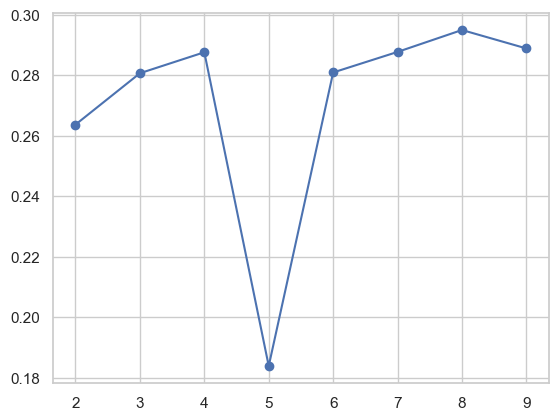

In [286]:

from sklearn.cluster import KMeans
import sklearn.metrics as metrics

#Liste pour stocker nos coefficients
silhouettes = [] 

#Boucle itérative de 2 à 10 clusters pour tester toutes les possibilités de k
for k in range(2, 10): 
    #Création et ajustement d'un modèle pour chaque k
    cls = KMeans(n_clusters=k, random_state=0)  
    cls.fit(variables_echelle)
    
    #Stockage des coefficients associés
    silh = metrics.silhouette_score(variables_echelle, cls.labels_)
    silhouettes.append(silh)
    
#Visualisation des valeurs de coefficient de silhouette pour chaque nombre de cluster
plt.plot(range(2, 10), silhouettes, marker='o')
plt.savefig('silhouette.png')
plt.show()



Malgré le cpef de silhouette, nous prenons le reisque de conserver le meme nombre de clusters que dans la méthode précédente k=5

- <font color='skyblue'> **Méthode du coude** </font>

Nous allons plutôt observer la décroissance de l’inertie intra-classe pour déterminer la meilleure valeur de k. En traçant la courbe de l’inertie intra-classe en fonction de k, nous cherchons alors à identifier les étapes où l’on observe une rupture dans la décroissance de cette courbe.

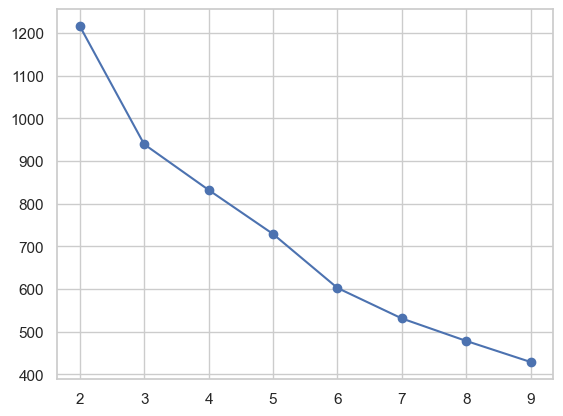

In [287]:
#Méthode du coude
#On crée une liste dans laquelle on stocke les inerties
inerties=[]

#On fait une boucle de 2 à 9 pour tester toutes ces possibiliéts
for k in range(2, 10):
    #pour chaque k, on crée un modèle et on l’ajuste
    km = KMeans(n_clusters=k, random_state=0)
    km.fit(variables_echelle)
    #on stocke l’inertie associée
    inerties.append(km.inertia_)

#Visualisation des valeurs d'inertie pour chaque nombre de cluster
plt.plot(range(2, 10), inerties, marker='o')

plt.savefig('coude.png')
plt.show()



 Cette courbe ne nous renseige pas car aucun coude se forme dans notre courbe.

- <font color='skyblue'> **Algorithme de K-means** </font>

Application de l'algorithme K-means en considérant 5 classes.

In [288]:
# Création k-means 
kmeans = KMeans(n_clusters=5, n_init=20, init='k-means++', random_state=1)
kmeans.fit(variables_echelle)

# predit à quelle classe appartient chaque point 
classes_kmeans =  kmeans.predict(variables_echelle)
classes_kmeans

array([1, 3, 3, 1, 3, 1, 3, 3, 3, 1, 3, 3, 1, 3, 1, 3, 3, 3, 1, 1, 3, 3,
       1, 2, 3, 1, 0, 1, 1, 3, 3, 0, 3, 3, 1, 0, 0, 3, 1, 3, 3, 3, 1, 1,
       3, 1, 3, 3, 1, 2, 1, 3, 3, 3, 3, 0, 1, 1, 1, 3, 3, 1, 1, 1, 3, 1,
       1, 3, 1, 4, 1, 1, 1, 3, 3, 3, 3, 3, 3, 1, 3, 1, 1, 1, 3, 1, 3, 1,
       1, 1, 3, 3, 0, 1, 3, 1, 1, 1, 3, 1, 3, 1, 3, 1, 3, 1, 1, 1, 1, 1,
       1, 1, 3, 3, 0, 1, 1, 1, 3, 1, 1, 3, 3, 1, 3, 3, 1, 3, 3, 1, 1, 3,
       1, 3, 3, 1, 3, 3, 3, 3, 1, 1, 3, 3, 1, 3, 3, 1, 3, 3, 3, 1, 1, 3,
       1, 0, 1, 3, 1, 1, 1, 1, 3, 1, 1, 1, 1, 2])

Création d'un dataframe avec la classe k means attribuée

In [289]:
#nombre de pays par classe
print(np.unique(kmeans.labels_, return_counts=True))

#création d'un df avec une colonne classe kmeans
df_final_kmeans=df_final.copy()
df_final_kmeans['classe_k'] = kmeans.labels_
df_final_kmeans=df_final_kmeans.reset_index()
df_final_kmeans.head()

(array([0, 1, 2, 3, 4]), array([ 8, 80,  3, 76,  1], dtype=int64))


,pays,population,evolution_pop,pib_par_hab,indice_stabilite,dispo_volaille_kg_p_an,production_volaille_en_t,importation_volaille_en_t,indice_dependance_import,exportation_volaille_en_t,classe_k
0,Afghanistan,35643418.0,0.209120,2058.4,-2.80,1.76,28000.0,29000.0,1.035714,0.0,1
1,Afrique du Sud,56641209.0,0.085738,13860.3,-0.28,37.01,1665000.0,514000.0,0.308709,63000.0,3
2,Albanie,2879355.0,-0.011823,12771.0,0.38,11.45,13000.0,20000.0,1.538462,0.0,3
3,Algérie,41136546.0,0.128358,11737.4,-0.92,6.91,284000.0,2000.0,0.007042,0.0,1
4,Allemagne,82624374.0,0.015725,53071.5,0.59,18.05,1514000.0,842000.0,0.556143,646000.0,3


Création d'un dataframe par classe pour la suite :

In [290]:
#Dataframe de chaque cluster
classek0=df_final_kmeans[df_final_kmeans['classe_k']==0]
classek1=df_final_kmeans[df_final_kmeans['classe_k']==1]
classek2=df_final_kmeans[df_final_kmeans['classe_k']==2]
classek3=df_final_kmeans[df_final_kmeans['classe_k']==3]
classek4=df_final_kmeans[df_final_kmeans['classe_k']==4]

In [291]:
classek4

,pays,population,evolution_pop,pib_par_hab,indice_stabilite,dispo_volaille_kg_p_an,production_volaille_en_t,importation_volaille_en_t,indice_dependance_import,exportation_volaille_en_t,classe_k
69,Inde,1.354196e+09,0.083874,6182.9,-0.76,2.84,3804000.0,0.0,0.0,4000.0,4


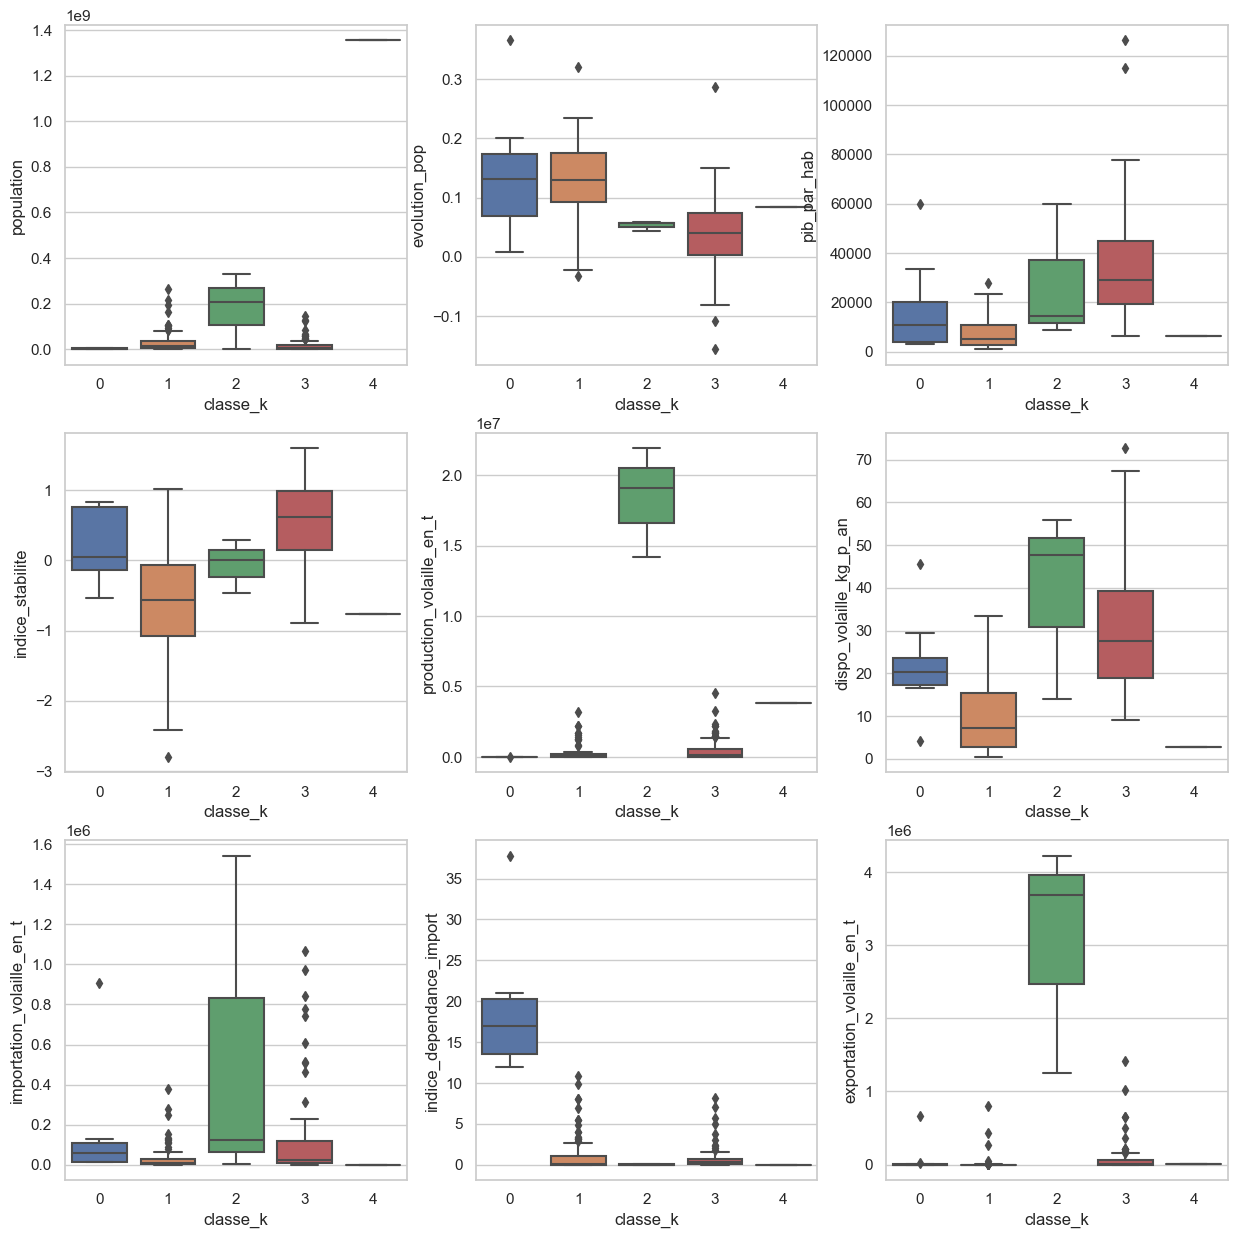

In [292]:
# affichage des variables en fonciton de la classe
plt.figure(figsize=(15, 15))
sns.set(style="whitegrid")
plt.subplot(6, 1, 1)

plt.subplot(331)
sns.boxplot(data=df_final_kmeans, x='classe_k', y='population')

plt.subplot(332)
sns.boxplot(data=df_final_kmeans, x='classe_k', y='evolution_pop')

plt.subplot(333)
sns.boxplot(data=df_final_kmeans, x='classe_k', y='pib_par_hab')

plt.subplot(334)
sns.boxplot(data=df_final_kmeans, x='classe_k', y='indice_stabilite')

plt.subplot(335)
sns.boxplot(data=df_final_kmeans, x='classe_k', y='production_volaille_en_t')

plt.subplot(336)
sns.boxplot(data=df_final_kmeans, x='classe_k', y='dispo_volaille_kg_p_an')

plt.subplot(337)
sns.boxplot(data=df_final_kmeans, x='classe_k', y='importation_volaille_en_t')

plt.subplot(338)
sns.boxplot(data=df_final_kmeans, x='classe_k', y='indice_dependance_import')

plt.subplot(339)
sns.boxplot(data=df_final_kmeans, x='classe_k', y='exportation_volaille_en_t')

plt.savefig("boxplotclasse_ks.png")
plt.show()

- <font color='skyblue'> **Analyse des classes** </font>

In [293]:
#Création d'un dataframe des moyennes pour chaque classe 
df_final_kmeans_moyenne=df_final_kmeans.groupby('classe_k').mean().round (decimals=2) 
df_final_kmeans_moyenne.head()

,population,evolution_pop,pib_par_hab,indice_stabilite,dispo_volaille_kg_p_an,production_volaille_en_t,importation_volaille_en_t,indice_dependance_import,exportation_volaille_en_t
classe_k,,,,,,,,,
0,3.017220e+06,0.14,17618.95,0.20,21.96,5750.00,161375.00,18.83,85000.00
1,3.323152e+07,0.13,6967.30,-0.64,9.79,300387.50,33100.00,1.29,20200.00
2,1.799127e+08,0.05,27752.13,-0.06,39.18,18390666.67,556333.33,0.03,3054333.33
3,1.795905e+07,0.04,34312.32,0.54,31.05,527394.74,131842.11,0.83,92513.16
4,1.354196e+09,0.08,6182.90,-0.76,2.84,3804000.00,0.00,0.00,4000.00


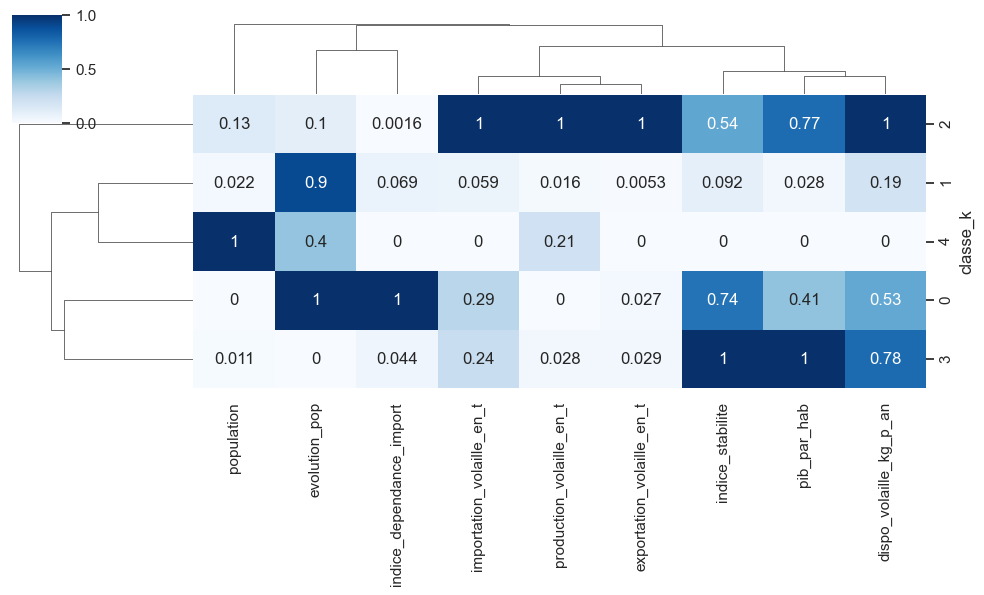

In [294]:
#Clustermap entre classes et variables
sns.clustermap(df_final_kmeans_moyenne, figsize=(10, 6), annot=True, standard_scale=1, cmap='Blues')
plt.savefig("clustermap.png")
plt.show()

- Classe k 0 : Pays stables et riches produisent et consomment de la volaille
- Classe k 1 : Pays pauvres et instables
- Classe k 2 : Pays très gros producteurs et exportateurs de volaille
- Classe k 3 : Pays riches et stables qui importent et consomment de la volaille
- Classe k 4 : Inde pays très peuplé

- <font color='skyblue'> **Scoring des pays selon leur performances sur les variables** </font>

Afin de faire une selection à l'intérieur de notre classe, nous allons crée un dataframe avec les valeurs pondérées et les ajouter afin d'obtenir un score qui discriminera les pays en fonction de leur performances dans chaque domaine.

In [295]:
#création d'une copie du df
classek3ponderee=classek3.copy()

In [296]:
#extraction des valeurs maximales pour calcul valeurs pondérées
max_popk = max(classek3.population)
max_evopopk = max(classek3.evolution_pop)
max_pibk = max(classek3.pib_par_hab)
max_stabk = max(classek3.indice_stabilite)
max_dispok = max(classek3.dispo_volaille_kg_p_an)
max_dependk = max(classek3.indice_dependance_import)
max_impok = max(classek3.importation_volaille_en_t)

#extraction des valeurs minimales pour calcul valeurs pondérées
min_evopopk = min(classek3.evolution_pop)
min_stabk = min(classek3.indice_stabilite)

In [297]:
#calcul des valeurs pondérées pour chaque variable
classek3ponderee['population']=classek3ponderee['population']/max_popk
classek3ponderee['evolution_pop']=(classek3ponderee['evolution_pop']+abs(min_evopopk))/(max_evopopk+abs(min_evopopk))
classek3ponderee['pib_par_hab']=classek3ponderee['pib_par_hab']/max_pibk
classek3ponderee['indice_stabilite']=(classek3ponderee['indice_stabilite']+abs(min_stabk))/(max_stabk+abs(min_stabk))
classek3ponderee['dispo_volaille_kg_p_an']=classek3ponderee['dispo_volaille_kg_p_an']/max_dispok
classek3ponderee['indice_dependance_import']=classek3ponderee['indice_dependance_import']/max_dependk
classek3ponderee['importation_volaille_en_t']=classek3ponderee['importation_volaille_en_t']/max_impok

In [298]:
#calcul d'un score où chaque variable a le meme poids 1/8
classek3ponderee['score_km']=(classek3ponderee['population']*4+ classek3ponderee['pib_par_hab'] + classek3ponderee['indice_stabilite'] + classek3ponderee['dispo_volaille_kg_p_an'] + classek3ponderee['indice_dependance_import']+ classek3ponderee['evolution_pop']+ classek3ponderee['importation_volaille_en_t']*4)*100/13

classek3ponderee=classek3ponderee.sort_values(by=['score_km'], ascending=False).reset_index(drop=True)

classek3ponderee.head(10)

,pays,population,evolution_pop,pib_par_hab,indice_stabilite,dispo_volaille_kg_p_an,production_volaille_en_t,importation_volaille_en_t,indice_dependance_import,exportation_volaille_en_t,classe_k,score_km
0,Japon,0.870817,0.327567,0.328547,0.803213,0.254608,2215000.0,1.000000,0.059160,10000.0,3,71.202769
1,Mexique,0.844532,0.542723,0.156340,0.036145,0.464512,3249000.0,0.909261,0.036672,9000.0,3,63.473552
2,Allemagne,0.568050,0.388791,0.420722,0.594378,0.248281,1514000.0,0.787652,0.068172,646000.0,3,54.947325
3,Royaume-Uni de Grande-Bretagne et d'Irlande du...,0.454202,0.466226,0.367615,0.514056,0.449243,1839000.0,0.728718,0.051925,359000.0,3,50.621130
4,Fédération de Russie,1.000000,0.387590,0.205530,0.100402,0.438102,4542000.0,0.211413,0.006099,116000.0,3,46.025948
5,Arabie saoudite,0.235081,0.668985,0.375017,0.100402,0.523246,540000.0,0.695978,0.168889,47000.0,3,42.775178
6,France,0.440997,0.413107,0.353383,0.469880,0.305365,1750000.0,0.473340,0.035443,501000.0,3,40.265552
7,Émirats arabes unis,0.062345,0.499315,0.532594,0.606426,0.357221,57000.0,0.434986,1.000000,31000.0,3,38.345245
8,Afrique du Sud,0.389414,0.546861,0.109877,0.244980,0.509078,1665000.0,0.480823,0.037842,63000.0,3,37.919885
9,Pays-Bas (Royaume des),0.118301,0.430711,0.436712,0.726908,0.220770,1099000.0,0.568756,0.067815,1418000.0,3,35.624187


In [299]:
map_paysrt = pd.DataFrame(classek3ponderee["pays"])
map_paysrt["score"]=classek3ponderee["score_km"]
map_paysrt.head(20)

,pays,score
0,Japon,71.202769
1,Mexique,63.473552
2,Allemagne,54.947325
3,Royaume-Uni de Grande-Bretagne et d'Irlande du...,50.621130
4,Fédération de Russie,46.025948
5,Arabie saoudite,42.775178
6,France,40.265552
7,Émirats arabes unis,38.345245
8,Afrique du Sud,37.919885
9,Pays-Bas (Royaume des),35.624187


- <font color='skyblue'> **Conclusion** </font>

Le Japon arrive à nouveau 1er du classement suivi de près par le Mexique.
L'Allemagne Hong Kong et le RU les talonnent comme avec la méthode précédente.

## <font color='skyblue'> 3) Analyse en composantes principales </font>

 L'analyse en composantes principales permet d'identifier des “profils cachés” dans notre jeu de données, de réduire les dimensions des données en enlevant la redondance des données et d'identifier les variables corrélées.

- <font color='skyblue'> **Préparation** </font>

Le nombre de composantes à conserver est déterminé en analysant l'éboulis des valeurs propres obtenu à partir de l'analyse en composantes principales. Les valeurs les plus importantes sont ceux-là qui expliquent le plus la variabilité.

In [300]:
#Nous allons travailler que sur les 4 premières composantes, création d'une liste avec les composates :
n_components = 4
pca = PCA(n_components=n_components)
pca.fit(variables_echelle)
pca.explained_variance_ratio_
#création df avec la mesure des variances
scree = (pca.explained_variance_ratio_*100).round(2)
#somme cumulée
scree_cum = scree.cumsum().round()
scree_cum
x_list = range(1, n_components+1)
list(x_list)

[1, 2, 3, 4]

- <font color='skyblue'> **Eboulis** </font>

Les valeurs propres sont des mesures de l'importance relative de chaque composante principale. L'éboulis des valeurs propres est utilisé pour interpréter la variabilité expliquée par chaque composante principale et pour déterminer le nombre optimal de dimensions à conserver.

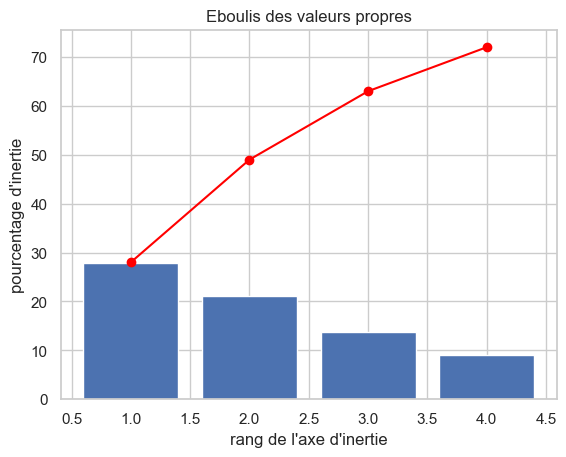

In [301]:
plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

La variance est distribuée de manière équitable

- <font color='skyblue'> **Heatmap des composantes** </font>

Une heatmap des composantes principales peut être très utile pour visualiser la corrélation des variables. Elle affichera quelles variables sont corrélées entre elles et avec les composantes principales, et elle permettra d'identifier des groupes de variables et des lignes de tendance.

<Axes: >

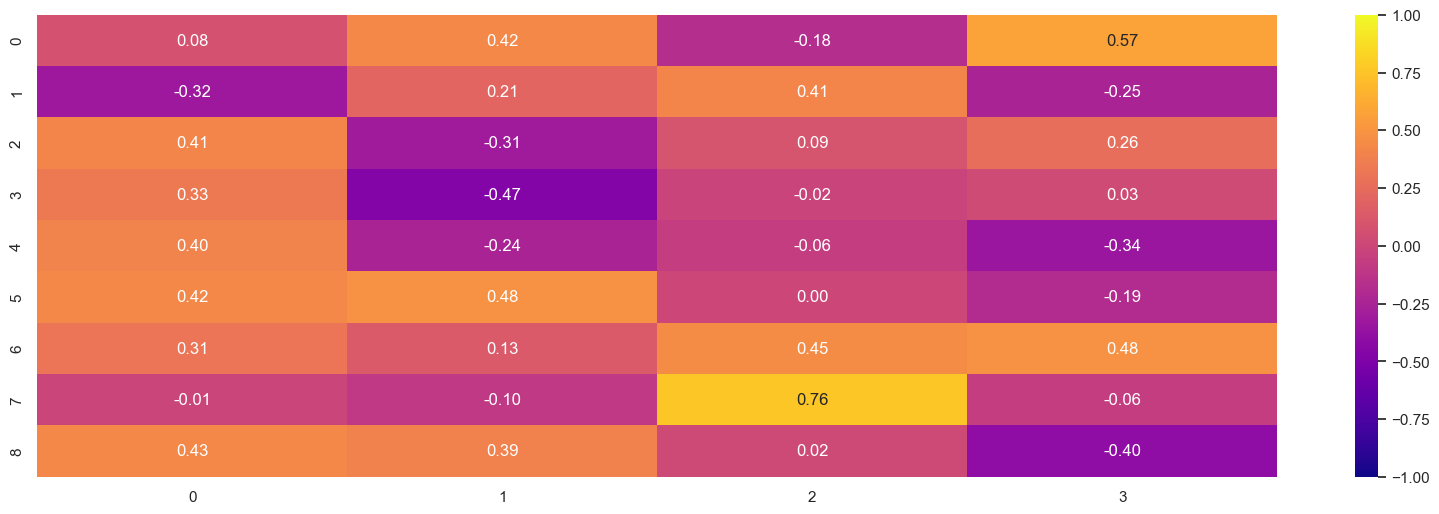

In [317]:
pcs = pca.components_
pcs.T
#visuel
fig, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="plasma", fmt="0.2f")

- La composante 0 est corrélée aux lignes 2, 3 et 4
- La composante 1 est correlée aux lignes 0 et 6
- La composante 2 n'a pas de corrélations 
- La composante 3 est correlée à la ligne 7


- <font color='skyblue'> **Cercle de corrélations** </font>

Le cercle des corrélations est utilisé pour visualiser les coefficients de corrélation entre les variables et les composantes principales. Cela aide à visualiser les variables qui sont les plus liées aux composantes principales et les variables qui sont les plus corrélées entre elles.

In [303]:
# création d'un array avec le nom des variables
noms_variables = df_final.columns
# mise en forme du pcs en dataframe
pcs = pd.DataFrame(pcs)
pcs

,0,1,2,3,4,5,6,7,8
0,0.077380,-0.321123,0.406359,0.330899,0.396193,0.422390,0.311692,-0.011394,0.428494
1,0.423760,0.209208,-0.306727,-0.466192,-0.243261,0.478457,0.126442,-0.095501,0.389920
2,-0.176257,0.413790,0.088969,-0.016081,-0.063394,0.002762,0.451585,0.762411,0.017656
3,0.571610,-0.246674,0.259031,0.026121,-0.338418,-0.189439,0.477117,-0.064372,-0.403033


In [304]:
# utilisation de l'array pour renommer les colomnes du pcs
pcs.columns = noms_variables
pcs.index = [f"F{i}" for i in x_list]
pcs.round(2)

,population,evolution_pop,pib_par_hab,indice_stabilite,dispo_volaille_kg_p_an,production_volaille_en_t,importation_volaille_en_t,indice_dependance_import,exportation_volaille_en_t
F1,0.08,-0.32,0.41,0.33,0.40,0.42,0.31,-0.01,0.43
F2,0.42,0.21,-0.31,-0.47,-0.24,0.48,0.13,-0.10,0.39
F3,-0.18,0.41,0.09,-0.02,-0.06,0.00,0.45,0.76,0.02
F4,0.57,-0.25,0.26,0.03,-0.34,-0.19,0.48,-0.06,-0.40


Affichage graphique de la corrélation entre les différentes composantes via la fonction prédéfinie.

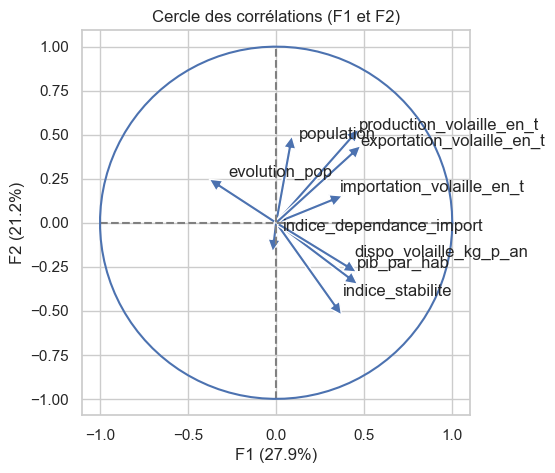

In [305]:
correlation_graph(pca, (0,1), noms_variables)

La production et l'exportation en volailles sont fortement correlés sur les 2 premières composantes, ils sont aussi en corrélation avec la population et l'importation à moindre mesure

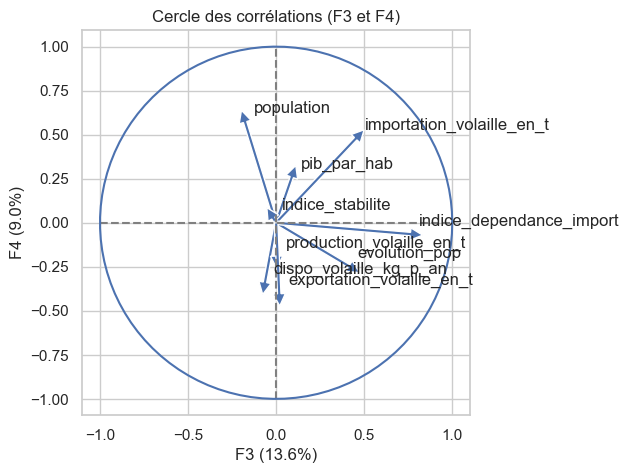

In [306]:
correlation_graph(pca, (2,3), noms_variables)

l'importation et le PIB sont fortement corrélés sur les 2 composantes suivantes.

- <font color='skyblue'> **Projections des classes CAH** </font>

Le but de la projection des individus sur F1 et F2 est de visualiser les individus dans un système à deux dimensions afin de mieux comprendre l'organisation des données et d'identifier des clusters ou des groupes d'individus. Il est également possible d'utiliser cette approche pour évaluer la force des corrélations entre les variables et les composantes principales.

In [307]:
#Tout d'abord calculons les coordonnées de nos individus dans le nouvel espace : 
X_proj = pca.transform(variables_echelle)
X_proj[:5]

array([[-2.64052391,  2.07000001,  0.39137248, -0.26805959],
       [ 0.95023106,  0.45257992,  0.49175553,  0.60426841],
       [-0.1586751 , -0.62444835, -0.68176396,  0.24227488],
       [-1.28809913,  0.72383536, -0.27313646,  0.01112575],
       [ 2.85928145,  0.25967486,  1.07198485,  2.10697878]])

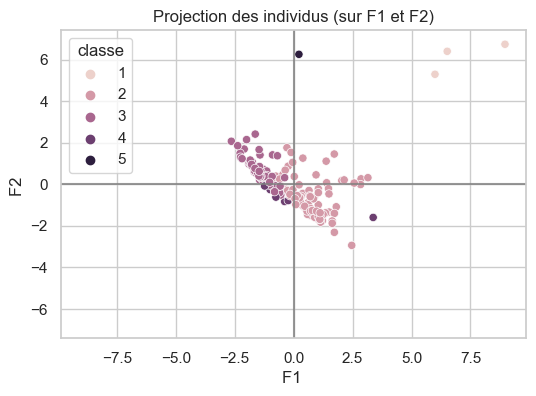

None


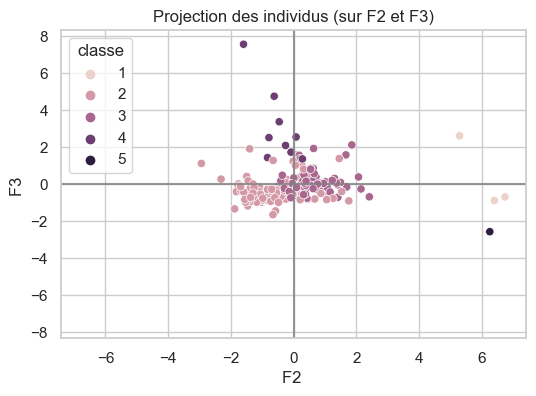

None


In [308]:
print(display_factorial_planes(   X_proj, 
                                (0,1), 
                                pca=None, 
                                labels = None,
                                clusters=df_final_cah['classe'], 
                                alpha=1,
                                figsize=[6,4], 
                                marker="." ))

print(display_factorial_planes(   X_proj, 
                                (1,2), 
                                pca=None, 
                                labels = None,
                                clusters=df_final_cah['classe'], 
                                alpha=1,
                                figsize=[6,4], 
                                marker="." ))


- <font color='skyblue'> **Projections des classes Kmeans** </font>

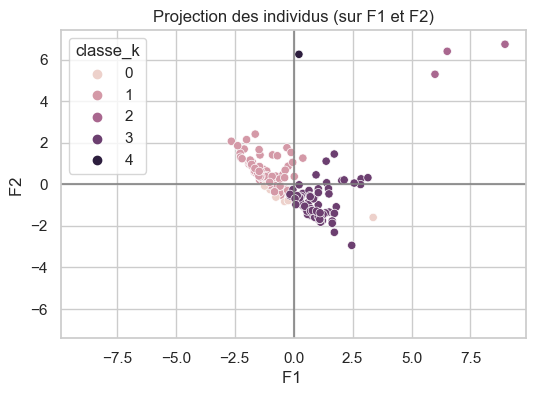

None


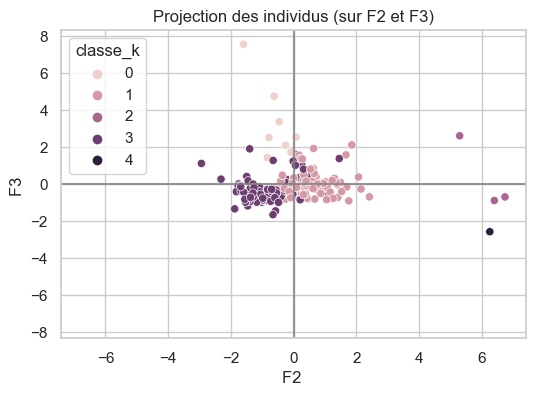

None


In [309]:
print(display_factorial_planes(   X_proj, 
                                (0,1), 
                                pca=None, 
                                labels = None,
                                clusters=df_final_kmeans['classe_k'], 
                                alpha=1,
                                figsize=[6,4], 
                                marker="." ))

print(display_factorial_planes(   X_proj, 
                                (1,2), 
                                pca=None, 
                                labels = None,
                                clusters=df_final_kmeans['classe_k'], 
                                alpha=1,
                                figsize=[6,4], 
                                marker="." ))


- <font color='skyblue'> **Projections par pays** </font>

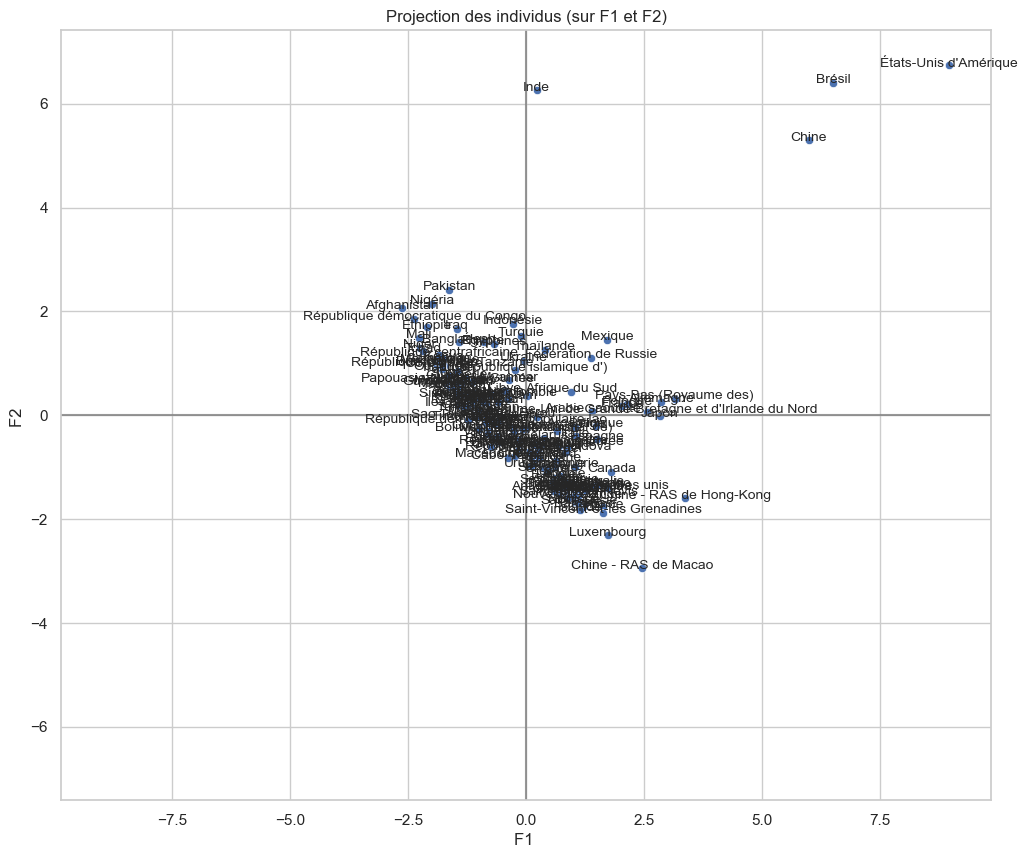

None


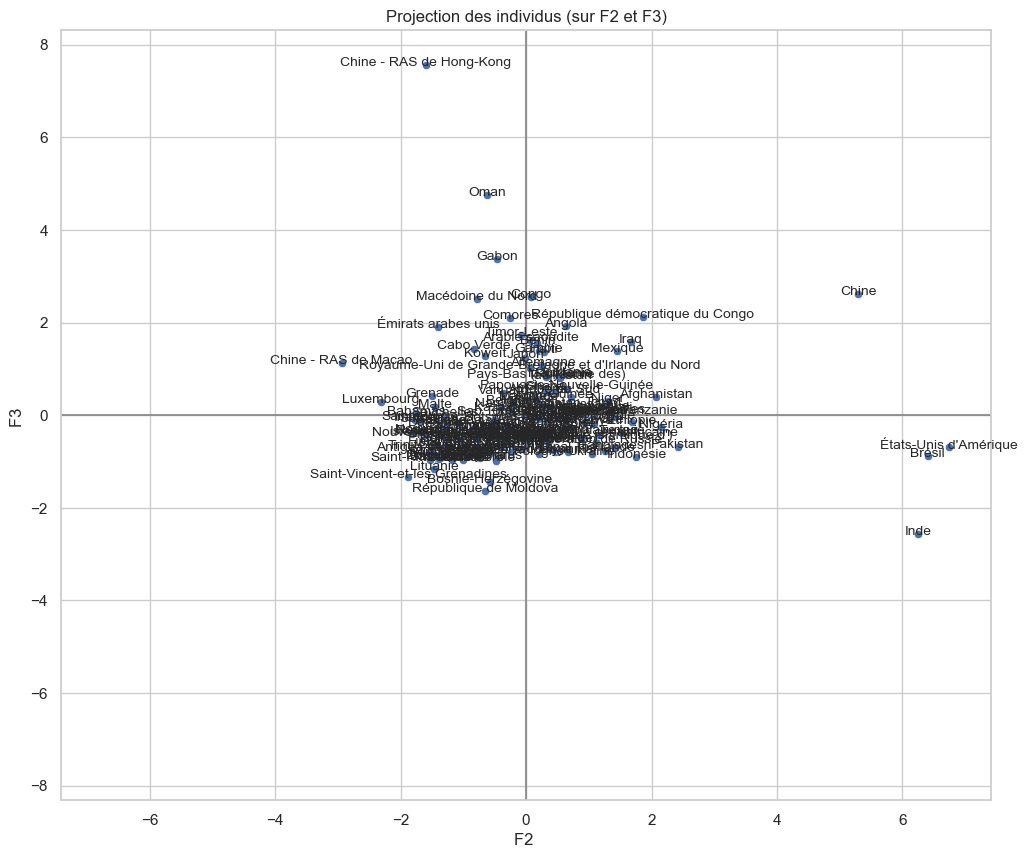

None


In [310]:
print(display_factorial_planes(   X_proj, 
                                (0,1), 
                                pca=None, 
                                labels = df_final_cah['pays'],
                                clusters=None, 
                                alpha=1,
                                figsize=[12,10], 
                                marker="." ))
print(display_factorial_planes(   X_proj, 
                                (1,2), 
                                pca=None, 
                                labels = df_final_cah['pays'],
                                clusters=None, 
                                alpha=1,
                                figsize=[12,10], 
                                marker="." ))


- <font color='skyblue'> **Conclusion** </font>

Lorsqu'on affiche les projections, les individus se trouvant dans la partie haute droite sont ceux qui dépendent le plus des composantes. Ainsi, on peut observer les informations suivantes :
- CAH : Les classes 4 et 5 dépendent des composantes 0 et 1 & les classes 1 et 5 dépendent des composantes 2 et 3
- KM : Les classes 4 et 1 dépendent des composantes 0 et 1 & les classes 3 et 4 dépendent des composantes 2 et 3
- Pays : Les USA, le Brésil ou la Russie dépendent des composantes 0 et 1 & le Vietnam, le Nigéria, l'Iran, et l'Inde dépendent des composantes 2 et 3

## <font color='skyblue'> 5) Conclusion</font>

Pour apporter une conslusion éclairée, une carte sera crée afin d'afficher les pays aux scores important, afin de detecter des clusters géographiques.

In [311]:
#création d'un dataframe avec les pays les plus intéressants pour la map
map_pays = pd.DataFrame(classek3ponderee["pays"])
map_pays["score"]=classek3ponderee["score_km"]
#séléction top 20
map_pays20=map_pays.head(20)
#attribution d'un code pour lecture par plotly
map_pays20['code']=["JPN","MEX","DEU","GBR","RUS","SAU","FRA","ARE","ZAF","NLD","CAN","MAC","ESP","KOR","ITA","KWT","AUS","BEL","ARG","GRD"]
map_pays20

,pays,score,code
0,Japon,71.202769,JPN
1,Mexique,63.473552,MEX
2,Allemagne,54.947325,DEU
3,Royaume-Uni de Grande-Bretagne et d'Irlande du...,50.621130,GBR
4,Fédération de Russie,46.025948,RUS
5,Arabie saoudite,42.775178,SAU
6,France,40.265552,FRA
7,Émirats arabes unis,38.345245,ARE
8,Afrique du Sud,37.919885,ZAF
9,Pays-Bas (Royaume des),35.624187,NLD


In [312]:
#suppression france et russie
map_pays20.drop([6,4], inplace=True)

In [314]:
#correction chine sur dataframe
liste1 = ["Indonésie", 39.9, "IDN" ]
map_pays20.loc[len(map_pays20)] = liste1

In [315]:

import plotly.graph_objects as go
import pandas as pd

fig = go.Figure(data=go.Choropleth(
    locations = map_pays20['code'],
    z = map_pays20['score'],
    text = map_pays20['pays'],
    colorscale = 'plasma',
    autocolorscale=False,
    reversescale=True,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_title = 'Score',

))

fig.update_layout(
    title_text='Pays les plus propices à une internationalisation',
    geo=dict(
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'
        
    ),
    width=1800,
    height=1000,
    annotations = [dict(
        x=0.55,
        y=0.1,
        xref='paper',
        yref='paper',
        showarrow = False,
        text='La poule qui chante'
    
    )]
)

fig.show()

Nous distinguons plusieurs régions propices à l'internationalisation. 
- La premièr la plus évidente car proche, et la zone europééne avec en tête de liste l'allemagne et le RU, suivi par la belgique l'espagne et l'italie. 
- La deuxièeme région est l'asie de l'Est avec 2 pays dont celui qui truste le haut du classement : le Japon et la Corée.
- La troisième est le moyen orient : avec l'arabie et les émirats arabes unis. 
- Enfin la dernière région est l'amérique du Sud avec le Mexique 2ème de notre classement suivi de l'argentine. 